# ML Ops Final Project
## EDA and Versioning
- Perform additional cleaning of final_compiled
- EDA on final_compiled
- Create different versions of the dataset for analysis

### Load final_compiled dataset

In [0]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
spark_final_compiled = spark.table("default.final_compiled")
final_compiled_pd = spark_final_compiled.toPandas()

In [0]:
final_compiled_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120650 entries, 0 to 120649
Columns: 106 entries, job_id to time_recorded
dtypes: datetime64[ns](4), float64(57), int64(31), object(14)
memory usage: 97.6+ MB


In [0]:
final_compiled_pd.head()

,job_id,company_name,title,description_x,location,company_id,views,applies,original_listed_time,remote_allowed,job_posting_url,application_url,expiry,listed_time,normalized_salary,zip_code,fips,city,state,work_type_Contract,work_type_Full-time,work_type_Internship,work_type_Other,work_type_Part-time,work_type_Temporary,work_type_Volunteer,experience_Associate,experience_Director,experience_Entry_level,experience_Executive,experience_Internship,experience_Mid-Senior_level,experience_unspecified,pay_period_BIWEEKLY,pay_period_HOURLY,pay_period_MONTHLY,pay_period_WEEKLY,pay_period_YEARLY,currency_BBD,currency_CAD,...,skill_Legal,skill_Management,skill_Manufacturing,skill_Marketing,skill_Other,skill_Product_Management,skill_Production,skill_Project_Management,skill_Public_Relations,skill_Purchasing,skill_Quality_Assurance,skill_Research,skill_Sales,skill_Science,skill_Strategy/Planning,skill_Supply_Chain,skill_Training,skill_Writing/Editing,job_industry,benefit_401_k_,benefit_Child_care_support,benefit_Commuter_benefits,benefit_Dental_insurance,benefit_Disability_insurance,benefit_Medical_insurance,benefit_Paid_maternity_leave,benefit_Paid_paternity_leave,benefit_Pension_plan,benefit_Student_loan_assistance,benefit_Tuition_assistance,benefit_Vision_insurance,name,description_y,company_size,company_hq_country,company_industry,company_specialities,employee_count,follower_count,time_recorded
0,3905284609,oak street health,outreach executive i,description\n\ncompany: oak street health\n\nt...,"tucson, az",3029525.0,3.0,0.0,2024-04-18 20:11:46,0.0,https://www.linkedin.com/jobs/view/3905284609/...,https://jobs.jobvite.com/oak-street-health/job...,2024-05-18 20:23:04,2024-04-18 20:23:04,NaN,85701.0,4019.0,tucson,az,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Hospitals And Health Care,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Oak Street Health,"Founded in 2012, Oak Street Health is a networ...",6.0,US,Hospitals And Health Care,"Primary Care Health Centers, Medicare, Concier...",3780.0,113611.0,2024-04-18 17:04:11
1,3905284610,oak street health,"nurse practitioner, advanced practice provider",description\n\ntitle: nurse practitioner - adv...,"albuquerque, nm",3029525.0,3.0,0.0,2024-04-18 20:11:47,0.0,https://www.linkedin.com/jobs/view/3905284610/...,https://jobs.jobvite.com/oak-street-health/job...,2024-05-18 20:23:04,2024-04-18 20:23:04,NaN,87101.0,35001.0,albuquerque,nm,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hospitals And Health Care,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Oak Street Health,"Founded in 2012, Oak Street Health is a networ...",6.0,US,Hospitals And Health Care,"Primary Care Health Centers, Medicare, Concier...",3780.0,113611.0,2024-04-18 17:04:11
2,3905284614,oak street health,medical assistant/phlebotomist,description\n\ncompany: oak street health\n\nt...,"aurora, co",3029525.0,4.0,0.0,2024-04-18 20:11:56,0.0,https://www.linkedin.com/jobs/view/3905284614/...,https://jobs.jobvite.com/oak-street-health/job...,2024-05-18 20:23:04,2024-04-18 20:23:04,NaN,80010.0,8001.0,aurora,co,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hospitals And Health Care,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Oak Street Health,"Founded in 2012, Oak Street Health is a networ...",6.0,US,Hospitals And Health Care,"Primary Care Health Centers, Medicare, Concier...",3780.0,113611.0,2024-04-18 17:04:11
3,3905284616,lantheus,"director, quality systems & compliance (hybrid)","lantheus is headquartered in bedford, massachu...","billerica, ma",249830.0,4.0,0.0,2024-04-18 00:00:00,0.0,https://www.linkedin.com/jobs/view/3905284616/...,https://recruiting.ultipro.com/LAN1018LMII/Job...,2024-05-18 20:27:01,2024-04-18 20:27:01,NaN,1821.0,25017.0,billerica,ma,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0

In [0]:
final_compiled_pd.describe()

,job_id,company_id,views,applies,remote_allowed,normalized_salary,zip_code,fips,work_type_Contract,work_type_Full-time,work_type_Internship,work_type_Other,work_type_Part-time,work_type_Temporary,work_type_Volunteer,experience_Associate,experience_Director,experience_Entry_level,experience_Executive,experience_Internship,experience_Mid-Senior_level,experience_unspecified,pay_period_BIWEEKLY,pay_period_HOURLY,pay_period_MONTHLY,pay_period_WEEKLY,pay_period_YEARLY,currency_BBD,currency_CAD,currency_EUR,currency_GBP,currency_USD,app_type_ComplexOnsiteApply,app_type_OffsiteApply,app_type_SimpleOnsiteApply,app_type_UnknownApply,link_to_application,salary_listed,skill_Accounting/Auditing,skill_Administrative,...,skill_Education,skill_Engineering,skill_Finance,skill_General_Business,skill_Health_Care_Provider,skill_Human_Resources,skill_Information_Technology,skill_Legal,skill_Management,skill_Manufacturing,skill_Marketing,skill_Other,skill_Product_Management,skill_Production,skill_Project_Management,skill_Public_Relations,skill_Purchasing,skill_Quality_Assurance,skill_Research,skill_Sales,skill_Science,skill_Strategy/Planning,skill_Supply_Chain,skill_Training,skill_Writing/Editing,benefit_401_k_,benefit_Child_care_support,benefit_Commuter_benefits,benefit_Dental_insurance,benefit_Disability_insurance,benefit_Medical_insurance,benefit_Paid_maternity_leave,benefit_Paid_paternity_leave,benefit_Pension_plan,benefit_Student_loan_assistance,benefit_Tuition_assistance,benefit_Vision_insurance,company_size,employee_count,follower_count
count,1.206500e+05,1.206500e+05,120650.000000,120650.000000,120650.000000,3.516300e+04,100736.000000,94341.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,120650.000000,119153.000000,119153.000000,...,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,119153.00000,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,119153.000000,28226.000000,28226.000000,28226.000000,28226.000000,28226.000000,28226.000000,28226.000000,28226.000000,28226.000000,28226.000000,28226.000000,28226.000000,120335.000000,120335.000000,1.203350e+05
mean,3.897073e+09,1.212698e+07,14.633809,2.003183,0.120174,2.082689e+05,50405.134937,28734.353452,0.097886,0.798002,0.007841,0.003688,0.078334,0.009681,0.004567,0.079047,0.030559,0.301268,0.009863,0.011960,0.339030,0.228272,0.000075,0.119726,0.004153,0.001467,0.166026,0.000017,0.000025,0.000041,0.000017,0.291347,0.241318,0.695715,0.062959,0.000008,0.716991,0.291446,0.040645,0.038337,...,0.018044,0.102968,0.065571,0.015904,0.136463,0.021166,0.207834,0.017708,0.167314,0.145846,0.044019,0.10181,0.010826,0.006169,0.031254,0.010289,0.004910,0.014435,0.024129,0.173189,0.006395,0.009341,0.009593,0.017650,0.011699,0.805002,0.009282,0.073833,0.225785,0.265819,0.326259,0.060618,0.051336,0.030468,0.012612,0.087579,0.308652,4.715561,17586.162405,5.025887e+05
std,7.073726e+07,2.547326e+07,86.192977,13.235102,0.325166,5.163124e+06,30237.945270,16007.769779,0.297162,0.401492,0.088201,0.060620,0.268698,0.097915,0.067425,0.269813,0.172122,0.458811,0.098823,0.108707,0.473382,0.419720,0.008637,0.324643,0.064306,0.038274,0.372105,0.004071,0.004986,0.006437,0.004071,0.454385,0.427884,0.460106,0.242890,0.002879,0.450462,0.454431,0.197468,0.192010,...,0.133111,0.303919,0.247532,0.125104,0.343281,0.143938,0.405759,0.131890,0.373258,0.352953,0.205138,0.30240,0.103486,0.078298,0.174004,0.100913,0.069897,0.119277,0.153449,0.378412,0.079714,0.096

In [0]:
pd.set_option('display.max_rows', None)

# Display the full list of missing values
print(final_compiled_pd.isnull().sum())

job_id                                 0
company_name                           0
title                                  0
description_x                          6
location                               0
company_id                             0
views                                  0
applies                                0
original_listed_time                   0
remote_allowed                         0
job_posting_url                        0
application_url                    34145
expiry                                 0
listed_time                            0
normalized_salary                  85487
zip_code                           19914
fips                               26309
city                                   0
state                                  0
work_type_Contract                     0
work_type_Full-time                    0
work_type_Internship                   0
work_type_Other                        0
work_type_Part-time                    0
work_type_Tempor

### Additional Cleaning
- rename description_x to job_description and description_y to company_description
- fill NAs in job_description with "No job description provided"
- drop application_url (just use link_to_application dummy)
- drop zip_code (use city and state for location)
- drop fips (use city and state for location)
- drop rows with NAs in skills
- drop all benefits dummies and just create a column for number of benefits listed
- drop NAs in name
- fill NAs in company_specialties with "None specified"
- fill NAs in company_industry with "Not specified"
- fill NAs in job_industry with "Not specified"
- one hot encode state
- group job_industry values into broader industry categories and then one hot encode

In [0]:
# Step 1: Rename columns
final_compiled_pd.rename(columns={'description_x': 'job_description', 'description_y': 'company_description'}, inplace=True)

# Step 2: Fill NAs in job_description
final_compiled_pd['job_description'].fillna("No job description provided", inplace=True)

# Step 3: Drop unnecessary columns
columns_to_drop = ['application_url', 'zip_code', 'fips']
final_compiled_pd.drop(columns=columns_to_drop, inplace=True)

# Step 4: Drop rows with NAs in skills
skills_columns = [col for col in final_compiled_pd.columns if col.startswith('skill_')]
final_compiled_pd.dropna(subset=skills_columns, inplace=True)

# Step 5: Create column for number of benefits listed
benefit_columns = [col for col in final_compiled_pd.columns if col.startswith('benefit_')]
final_compiled_pd['num_benefits'] = final_compiled_pd[benefit_columns].sum(axis=1)
final_compiled_pd.drop(columns=benefit_columns, inplace=True)

# Step 6: Drop NAs in name
final_compiled_pd.dropna(subset=['name'], inplace=True)

# Step 7: Fill NAs in company_specialties, company_industry, job_industry
final_compiled_pd['company_specialities'].fillna("None specified", inplace=True)
final_compiled_pd['company_industry'].fillna("Not specified", inplace=True)
final_compiled_pd['job_industry'].fillna("Not specified", inplace=True)

# Step 8: One-hot encode state and num_benefits
final_compiled = pd.get_dummies(final_compiled_pd, columns=['state'], prefix='state')

In [0]:
# Display unique values in the job_industry column
unique_industries = final_compiled['job_industry'].unique()

# Print the unique industries
print(f"Number of unique industries: {len(unique_industries)}")
print("Unique industries:")
print(unique_industries)

Number of unique industries: 359
Unique industries:
['Hospitals And Health Care' 'Pharmaceutical Manufacturing'
 'Medical Practices' 'Insurance' 'Staffing And Recruiting'
 'Software Development' 'Industrial Machinery Manufacturing'
 'Higher Education' 'Advertising Services' 'Food And Beverage Services'
 'Retail' 'Financial Services' 'Primary And Secondary Education'
 'Appliances, Electrical, And Electronics Manufacturing'
 'It Services And It Consulting' 'Business Content' 'Construction'
 'Manufacturing' 'Education' 'Hospitality' 'Non-Profit Organizations'
 'Entertainment Providers' 'Oil And Gas' 'Human Resources'
 'Individual And Family Services' 'Motor Vehicle Manufacturing'
 'Telecommunications' 'Real Estate' 'Utilities' 'Professional Services'
 'Technology, Information And Media' 'Biotechnology Research'
 'Government Administration' 'Investment Management'
 'Security And Investigations' 'Civil Engineering'
 'Medical Equipment Manufacturing' 'Marketing Services'
 'Research Services'

In [0]:
# Complete mapping of unique industries to broader categories
industry_mapping = {
    # Healthcare
    'Hospitals And Health Care': 'Healthcare',
    'Medical Practices': 'Healthcare',
    'Mental Health Care': 'Healthcare',
    'Nursing Homes And Residential Care Facilities': 'Healthcare',
    'Veterinary Services': 'Healthcare',
    'Dentists': 'Healthcare',
    'Alternative Medicine': 'Healthcare',
    'Medical Equipment Manufacturing': 'Healthcare',
    'Medical Device': 'Healthcare',
    'Physical, Occupational And Speech Therapists': 'Healthcare',
    'Home Health Care Services': 'Healthcare',
    'Medical And Diagnostic Laboratories': 'Healthcare',
    'Public Health': 'Healthcare',
    'Health, Wellness & Fitness': 'Healthcare',
    'Health And Human Services': 'Healthcare',
    'Wellness And Fitness Services': 'Healthcare',
    'Veterinary': 'Healthcare',
    'Hospitals': 'Healthcare',
    'Individual And Family Services': 'Healthcare',
    'Personal Care Services': 'Healthcare',
    'Biotechnology': 'Healthcare',
    'Biotechnology Research': 'Healthcare',
    
    # Technology
    'Software Development': 'Technology',
    'Information Technology & Services': 'Technology',
    'Computer Hardware Manufacturing': 'Technology',
    'Technology, Information And Media': 'Technology',
    'It Services And It Consulting': 'Technology',
    'Computer And Network Security': 'Technology',
    'Semiconductor Manufacturing': 'Technology',
    'Semiconductors': 'Technology',
    'Computer Hardware': 'Technology',
    'Computer Networking': 'Technology',
    'Data Infrastructure And Analytics': 'Technology',
    'Blockchain Services': 'Technology',
    'It System Data Services': 'Technology',
    'It System Training And Support': 'Technology',
    'It System Testing And Evaluation': 'Technology',
    'It System Operations And Maintenance': 'Technology',
    'It System Installation And Disposal': 'Technology',
    'It System Custom Software Development': 'Technology',
    'Desktop Computing Software Products': 'Technology',
    'Social Networking Platforms': 'Technology',
    'Online Media': 'Technology',
    'Internet Publishing': 'Technology',
    'Internet News': 'Technology',
    'Internet Marketplace Platforms': 'Technology',
    'Digital Accessibility Services': 'Technology',
    'Climate Technology Product Manufacturing': 'Technology',
    'Data Security Software Products': 'Technology',
    'Business Intelligence Platforms': 'Technology',
    'Climate Data And Analytics': 'Technology',
    'Computer Games': 'Technology',
    'Computer Networking Products': 'Technology',
    'Computers And Electronics Manufacturing': 'Technology',
    'Nanotechnology Research': 'Technology',
    'Robotics Engineering': 'Technology',
    'Space Research And Technology': 'Technology',
    'Wireless Services': 'Technology',
    'Technology, Information And Internet': 'Technology',
    'Telecommunications': 'Technology',
    'Program Development': 'Technology',
    'It System Design Services': 'Technology',
    'Information Services': 'Technology',

    # Finance
    'Financial Services': 'Finance',
    'Investment Management': 'Finance',
    'Investment Banking': 'Finance',
    'Banking': 'Finance',
    'Capital Markets': 'Finance',
    'Venture Capital And Private Equity Principals': 'Finance',
    'Credit Intermediation': 'Finance',
    'Pension Funds': 'Finance',
    'Loan Brokers': 'Finance',
    'Holding Companies': 'Finance',
    'Securities And Commodity Exchanges': 'Finance',
    'Insurance': 'Finance',
    'Insurance Agencies And Brokerages': 'Finance',
    'Insurance And Employee Benefit Funds': 'Finance',
    'Insurance Carriers': 'Finance',
    'Trusts And Estates': 'Finance',
    
    # Education
    'Higher Education': 'Education',
    'Primary And Secondary Education': 'Education',
    'Education': 'Education',
    'Education Management': 'Education',
    'Education Administration Programs': 'Education',
    'E-Learning Providers': 'Education',
    'E-Learning': 'Education',
    'Libraries': 'Education',
    'Technical And Vocational Training': 'Education',
    'Professional Training And Coaching': 'Education',
    'Sports And Recreation Instruction': 'Education',
    
    # Manufacturing
    'Industrial Machinery Manufacturing': 'Manufacturing',
    'Appliances, Electrical, And Electronics Manufacturing': 'Manufacturing',
    'Manufacturing': 'Manufacturing',
    'Machinery Manufacturing': 'Manufacturing',
    'Automotive': 'Manufacturing',
    'Motor Vehicle Manufacturing': 'Manufacturing',
    'Motor Vehicle Parts Manufacturing': 'Manufacturing',
    'Aviation And Aerospace Component Manufacturing': 'Manufacturing',
    'Paper And Forest Product Manufacturing': 'Manufacturing',
    'Chemical Manufacturing': 'Manufacturing',
    'Textile Manufacturing': 'Manufacturing',
    'Plastics Manufacturing': 'Manufacturing',
    'Glass, Ceramics And Concrete Manufacturing': 'Manufacturing',
    'Metalworking Machinery Manufacturing': 'Manufacturing',
    'Electrical Equipment Manufacturing': 'Manufacturing',
    'Furniture And Home Furnishings Manufacturing': 'Manufacturing',
    'Dairy Product Manufacturing': 'Manufacturing',
    'Beverage Manufacturing': 'Manufacturing',
    'Food And Beverage Manufacturing': 'Manufacturing',
    'Pharmaceutical Manufacturing': 'Manufacturing',
    'Medical Equipment Manufacturing': 'Manufacturing',
    'Hvac And Refrigeration Equipment Manufacturing': 'Manufacturing',
    'Packaging And Containers Manufacturing': 'Manufacturing',
    'Fabricated Metal Products': 'Manufacturing',
    'Rubber Products Manufacturing': 'Manufacturing',
    'Cosmetics': 'Manufacturing',
    'Paper & Forest Products': 'Manufacturing',
    'Oil And Coal Product Manufacturing': 'Manufacturing',
    'Apparel Manufacturing': 'Manufacturing',
    'Footwear Manufacturing': 'Manufacturing',
    'Audio And Video Equipment Manufacturing': 'Manufacturing',
    'Semiconductor Manufacturing': 'Manufacturing',
    'Robot Manufacturing': 'Manufacturing',
    'Computer Hardware Manufacturing': 'Manufacturing',
    'Electronic Component Manufacturing': 'Manufacturing',
    'Agricultural Chemical Manufacturing': 'Manufacturing',
    'Automation Machinery Manufacturing': 'Manufacturing',
    'Boilers, Tanks, And Shipping Container Manufacturing': 'Manufacturing',
    'Chemical Raw Materials Manufacturing': 'Manufacturing',
    'Commercial And Service Industry Machinery Manufacturing': 'Manufacturing',
    'Communications Equipment Manufacturing': 'Manufacturing',
    'Electric Lighting Equipment Manufacturing': 'Manufacturing',
    'Engines And Power Transmission Equipment Manufacturing': 'Manufacturing',
    'Fashion Accessories Manufacturing': 'Manufacturing',
    'Food Production': 'Manufacturing',
    'Glass Product Manufacturing': 'Manufacturing',
    'Mattress And Blinds Manufacturing': 'Manufacturing',
    'Measuring And Control Instrument Manufacturing': 'Manufacturing',
    'Meat Products Manufacturing': 'Manufacturing',
    'Metal Treatments': 'Manufacturing',
    'Packaging & Containers': 'Manufacturing',
    'Paint, Coating, And Adhesive Manufacturing': 'Manufacturing',
    'Plastics And Rubber Product Manufacturing': 'Manufacturing',
    'Primary Metal Manufacturing': 'Manufacturing',
    'Railroad Equipment Manufacturing': 'Manufacturing',
    'Renewable Energy Equipment Manufacturing': 'Manufacturing',
    'Renewable Energy Semiconductor Manufacturing': 'Manufacturing',
    'Seafood Product Manufacturing': 'Manufacturing',
    'Shipbuilding': 'Manufacturing',
    'Soap And Cleaning Product Manufacturing': 'Manufacturing',
    'Sporting Goods Manufacturing': 'Manufacturing',
    'Spring And Wire Product Manufacturing': 'Manufacturing',
    'Sugar And Confectionery Product Manufacturing': 'Manufacturing',
    'Tobacco Manufacturing': 'Manufacturing',
    'Transportation Equipment Manufacturing': 'Manufacturing',
    'Wineries': 'Manufacturing',
    'Wood Product Manufacturing': 'Manufacturing',
    'Wine & Spirits': 'Manufacturing',
    'Mattress And Blinds Manufacturing': 'Manufacturing',
    'Office Furniture And Fixtures Manufacturing': 'Manufacturing',
    'Furniture': 'Manufacturing',
    'Building Materials': 'Manufacturing',
    'Baked Goods Manufacturing': 'Manufacturing',
    'Meat Products Manufacturing': 'Manufacturing',
    'Electric Lighting Equipment Manufacturing': 'Manufacturing',
    'Metal Treatments': 'Manufacturing',
    'Boilers, Tanks, And Shipping Container Manufacturing': 'Manufacturing',
    'Packaging & Containers': 'Manufacturing',
    'Paint, Coating, And Adhesive Manufacturing': 'Manufacturing',
    'Glass Product Manufacturing': 'Manufacturing',
    'Mattress And Blinds Manufacturing': 'Manufacturing',
    'Robotics Engineering': 'Manufacturing',
    'Defense And Space Manufacturing': 'Manufacturing',
    'Industrial Automation': 'Manufacturing',
    'Personal Care Product Manufacturing': 'Manufacturing',

    # Retail
    'Retail': 'Retail',
    'Retail Apparel And Fashion': 'Retail',
    'Retail Groceries': 'Retail',
    'Retail Pharmacies': 'Retail',
    'Retail Office Equipment': 'Retail',
    'Retail Health And Personal Care Products': 'Retail',
    'Retail Luxury Goods And Jewelry': 'Retail',
    'Retail Furniture And Home Furnishings': 'Retail',
    'Retail Motor Vehicles': 'Retail',
    'Retail Appliances, Electrical, And Electronic Equipment': 'Retail',
    'Retail Art Supplies': 'Retail',
    'Retail Florists': 'Retail',
    'Retail Books And Printed News': 'Retail',
    'Retail Building Materials And Garden Equipment': 'Retail',
    'Retail Office Supplies And Gifts': 'Retail',
    'Retail Musical Instruments': 'Retail',
    'Food And Beverage Retail': 'Retail',
    'Food & Beverages': 'Retail',
    'Apparel & Fashion': 'Retail',
    'Consumer Electronics': 'Retail',
    'Consumer Goods': 'Retail',
    'Consumer Goods Rental': 'Retail',
    'Consumer Services': 'Retail',
    'Luxury Goods & Jewelry': 'Retail',
    'Wholesale': 'Retail',
    'Wholesale Alcoholic Beverages': 'Retail',
    'Wholesale Apparel And Sewing Supplies': 'Retail',
    'Wholesale Appliances, Electrical, And Electronics': 'Retail',
    'Wholesale Building Materials': 'Retail',
    'Wholesale Chemical And Allied Products': 'Retail',
    'Wholesale Computer Equipment': 'Retail',
    'Wholesale Food And Beverage': 'Retail',
    'Wholesale Footwear': 'Retail',
    'Wholesale Furniture And Home Furnishings': 'Retail',
    'Wholesale Hardware, Plumbing, Heating Equipment': 'Retail',
    'Wholesale Import And Export': 'Retail',
    'Wholesale Luxury Goods And Jewelry': 'Retail',
    'Wholesale Metals And Minerals': 'Retail',
    'Wholesale Motor Vehicles And Parts': 'Retail',
    'Wholesale Paper Products': 'Retail',
    'Wholesale Recyclable Materials': 'Retail',
    'Wholesale Petroleum And Petroleum Products': 'Retail',
    'Wholesale Machinery': 'Retail',
    'Retail Luxury Goods And Jewelry': 'Retail',

    # Energy
    'Oil And Gas': 'Energy',
    'Renewable Energy Power Generation': 'Energy',
    'Services For Renewable Energy': 'Energy',
    'Electric Power Transmission, Control, And Distribution': 'Energy',
    'Oil, Gas, And Mining': 'Energy',
    'Renewables & Environment': 'Energy',
    'Natural Gas Distribution': 'Energy',
    'Utilities': 'Energy',
    'Mining': 'Energy',
    'Water, Waste, Steam, And Air Conditioning Services': 'Energy',
    'Wholesale Petroleum And Petroleum Products': 'Energy',
    'Renewable Energy Equipment Manufacturing': 'Energy',
    'Renewable Energy Semiconductor Manufacturing': 'Energy',
    'Electric Power Generation': 'Energy',
    'Solar Electric Power Generation': 'Energy',
    'Wind Electric Power Generation': 'Energy',

    # Construction
    'Construction': 'Construction',
    'Building Construction': 'Construction',
    'Nonresidential Building Construction': 'Construction',
    'Residential Building Construction': 'Construction',
    'Utility System Construction': 'Construction',
    'Building Equipment Contractors': 'Construction',
    'Specialty Trade Contractors': 'Construction',
    'Civil Engineering': 'Construction',
    'Building Materials': 'Construction',
    'Accessible Architecture And Design': 'Construction',
    'Architecture And Planning': 'Construction',

    # Transportation
    'Airlines And Aviation': 'Transportation',
    'Truck Transportation': 'Transportation',
    'Transportation, Logistics, Supply Chain And Storage': 'Transportation',
    'Transportation/Trucking/Railroad': 'Transportation',
    'Freight And Package Transportation': 'Transportation',
    'Rail Transportation': 'Transportation',
    'Pipeline Transportation': 'Transportation',
    'Maritime Transportation': 'Transportation',
    'Urban Transit Services': 'Transportation',
    'Ground Passenger Transportation': 'Transportation',
    'School And Employee Bus Services': 'Transportation',
    'Aviation & Aerospace': 'Transportation',
    'Transportation Equipment Manufacturing': 'Transportation',
    'Transportation Programs': 'Transportation',
    'Vehicle Repair And Maintenance': 'Transportation',
    'Warehousing': 'Transportation',
    'Warehousing And Storage': 'Transportation',
    'Logistics': 'Transportation',
    'Motor Vehicle Parts Manufacturing': 'Transportation',
    'Maritime': 'Transportation',

    # Professional Services
    'Staffing And Recruiting': 'Professional Services',
    'Human Resources': 'Professional Services',
    'Business Consulting And Services': 'Professional Services',
    'Accounting': 'Professional Services',
    'Legal Services': 'Professional Services',
    'Law Practice': 'Professional Services',
    'Management Consulting': 'Professional Services',
    'Administrative And Support Services': 'Professional Services',
    'Translation And Localization': 'Professional Services',
    'Design Services': 'Professional Services',
    'Surveying And Mapping Services': 'Professional Services',
    'Graphic Design': 'Professional Services',
    'Alternative Dispute Resolution': 'Professional Services',
    'Architecture And Planning': 'Professional Services',
    'Engineering Services': 'Professional Services',
    'Operations Consulting': 'Professional Services',
    'Outsourcing And Offshoring Consulting': 'Professional Services',
    'Mechanical Or Industrial Engineering': 'Professional Services',
    'Research Services': 'Professional Services',
    'Executive Search Services': 'Professional Services',
    'Janitorial Services': 'Professional Services',
    'Landscaping Services': 'Professional Services',
    'Human Resources Services': 'Professional Services',
    'Market Research': 'Professional Services',
    'Marketing Services': 'Professional Services',
    'Executive Offices': 'Professional Services',
    'Public Relations And Communications Services': 'Professional Services',
    'Telephone Call Centers': 'Professional Services',
    'Environmental Services': 'Professional Services',
    'Equipment Rental Services': 'Professional Services',
    'Facilities Services': 'Professional Services',
    'Repair And Maintenance': 'Professional Services',
    'Security And Investigations': 'Professional Services',
    'Security Systems Services': 'Professional Services',
    'Strategic Management Services': 'Professional Services',
    'Household Services': 'Professional Services',
    'Professional Services': 'Professional Services',
    'Printing Services': 'Professional Services',
    'Research': 'Professional Services',
    'Alternative Dispute Resolution': 'Professional Services',
    'Accessible Architecture And Design': 'Professional Services',
    'Fire Protection': 'Professional Services',
    'Program Development': 'Professional Services',
    'Operations Consulting': 'Professional Services',
    'Commercial And Industrial Equipment Rental': 'Professional Services',
    'Design': 'Professional Services',
    'Interior Design': 'Professional Services',
    'International Trade And Development': 'Professional Services',
    'Office Administration': 'Professional Services',

    # Hospitality
    'Hospitality': 'Hospitality',
    'Hotels And Motels': 'Hospitality',
    'Restaurants': 'Hospitality',
    'Food And Beverage Services': 'Hospitality',
    'Events Services': 'Hospitality',
    'Leisure, Travel & Tourism': 'Hospitality',
    'Travel Arrangements': 'Hospitality',
    'Caterers': 'Hospitality',
    'Golf Courses And Country Clubs': 'Hospitality',
    'Amusement Parks And Arcades': 'Hospitality',
    'Gambling Facilities And Casinos': 'Hospitality',
    'Recreational Facilities': 'Hospitality',
    'Sports And Recreation Instruction': 'Hospitality',

    # Government
    'Government Administration': 'Government',
    'Public Policy Offices': 'Government',
    'Public Safety': 'Government',
    'Military And International Affairs': 'Government',
    'International Affairs': 'Government',
    'Legislative Offices': 'Government',
    'Armed Forces': 'Government',
    'Law Enforcement': 'Government',
    'Correctional Institutions': 'Government',
    'Housing Programs': 'Government',
    'Administration Of Justice': 'Government',
    'Economic Programs': 'Government',
    'Conservation Programs': 'Government',
    'Political Organizations': 'Government',
    'Fire Protection': 'Government',
    'Government Relations Services': 'Government',
    'Community Development And Urban Planning': 'Government',
    'Defense & Space': 'Government',

    # Media & Entertainment
    'Advertising Services': 'Media & Entertainment',
    'Media Production': 'Media & Entertainment',
    'Broadcast Media Production And Distribution': 'Media & Entertainment',
    'Online Audio And Video Media': 'Media & Entertainment',
    'Entertainment Providers': 'Media & Entertainment',
    'Entertainment': 'Media & Entertainment',
    'Movies, Videos, And Sound': 'Media & Entertainment',
    'Animation And Post-Production': 'Media & Entertainment',
    'Book And Periodical Publishing': 'Media & Entertainment',
    'Newspaper Publishing': 'Media & Entertainment',
    'Fine Art': 'Media & Entertainment',
    'Performing Arts': 'Media & Entertainment',
    'Museums, Historical Sites, And Zoos': 'Media & Entertainment',
    'Spectator Sports': 'Media & Entertainment',
    'Sports Teams And Clubs': 'Media & Entertainment',
    'Artists And Writers': 'Media & Entertainment',
    'Musicians': 'Media & Entertainment',
    'Photography': 'Media & Entertainment',
    'Writing And Editing': 'Media & Entertainment',
    'Performing Arts And Spectator Sports': 'Media & Entertainment',
    'Business Content': 'Media & Entertainment',
    'Computer Games': 'Media & Entertainment',

    # Non-Profit
    'Non-Profit Organizations': 'Non-Profit',
    'Non-Profit Organization Management': 'Non-Profit',
    'Civic And Social Organizations': 'Non-Profit',
    'Religious Institutions': 'Non-Profit',
    'Philanthropic Fundraising Services': 'Non-Profit',
    'Think Tanks': 'Non-Profit',
    'Community Services': 'Non-Profit',
    'Fundraising': 'Non-Profit',

    # Agriculture
    'Farming': 'Agriculture',
    'Agriculture, Construction, Mining Machinery Manufacturing': 'Agriculture',
    'Horticulture': 'Agriculture',
    'Forestry And Logging': 'Agriculture',
    'Animal Feed Manufacturing': 'Agriculture',
    'Agricultural Chemical Manufacturing': 'Agriculture',
    'Seafood Product Manufacturing': 'Agriculture',

    # Real Estate
    'Real Estate': 'Real Estate',
    'Commercial Real Estate': 'Real Estate',
    'Real Estate Agents And Brokers': 'Real Estate',
    'Leasing Non-Residential Real Estate': 'Real Estate',
    'Housing And Community Development': 'Real Estate',
    'Real Estate And Equipment Rental Services': 'Real Estate',

    # Utilities
    'Utilities': 'Utilities',
    'Water, Waste, Steam, And Air Conditioning Services': 'Utilities',
    'Air, Water, And Waste Program Management': 'Utilities',

    # Logistics
    'Logistics': 'Logistics',

    # Not Specified
    'Not specified': 'Not specified',
    'Unnamed Industry': 'Not specified'
}

# Apply the mapping to create the new column
final_compiled['job_industry_category'] = final_compiled['job_industry'].map(industry_mapping)

In [0]:
# Encode job_industry_category and add dummy variables to the DataFrame
final_compiled = pd.get_dummies(final_compiled, columns=['job_industry_category'], prefix='industry_')

# Drop the original job_industry column
final_compiled.drop(columns=['job_industry'], inplace=True)

In [0]:
final_compiled.shape

(118848, 161)

In [0]:
final_compiled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118848 entries, 0 to 120649
Columns: 161 entries, job_id to industry__Utilities
dtypes: datetime64[ns](4), float64(44), int64(31), object(11), uint8(71)
memory usage: 90.6+ MB


In [0]:
final_compiled.head()

,job_id,company_name,title,job_description,location,company_id,views,applies,original_listed_time,remote_allowed,job_posting_url,expiry,listed_time,normalized_salary,city,work_type_Contract,work_type_Full-time,work_type_Internship,work_type_Other,work_type_Part-time,work_type_Temporary,work_type_Volunteer,experience_Associate,experience_Director,experience_Entry_level,experience_Executive,experience_Internship,experience_Mid-Senior_level,experience_unspecified,pay_period_BIWEEKLY,pay_period_HOURLY,pay_period_MONTHLY,pay_period_WEEKLY,pay_period_YEARLY,currency_BBD,currency_CAD,currency_EUR,currency_GBP,currency_USD,app_type_ComplexOnsiteApply,...,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_united states,state_unspecified,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,industry__Agriculture,industry__Construction,industry__Education,industry__Energy,industry__Finance,industry__Government,industry__Healthcare,industry__Hospitality,industry__Manufacturing,industry__Media & Entertainment,industry__Non-Profit,industry__Not specified,industry__Professional Services,industry__Real Estate,industry__Retail,industry__Technology,industry__Transportation,industry__Utilities
0,3905284609,oak street health,outreach executive i,description\n\ncompany: oak street health\n\nt...,"tucson, az",3029525.0,3.0,0.0,2024-04-18 20:11:46,0.0,https://www.linkedin.com/jobs/view/3905284609/...,2024-05-18 20:23:04,2024-04-18 20:23:04,NaN,tucson,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,3905284610,oak street health,"nurse practitioner, advanced practice provider",description\n\ntitle: nurse practitioner - adv...,"albuquerque, nm",3029525.0,3.0,0.0,2024-04-18 20:11:47,0.0,https://www.linkedin.com/jobs/view/3905284610/...,2024-05-18 20:23:04,2024-04-18 20:23:04,NaN,albuquerque,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,3905284614,oak street health,medical assistant/phlebotomist,description\n\ncompany: oak street health\n\nt...,"aurora, co",3029525.0,4.0,0.0,2024-04-18 20:11:56,0.0,https://www.linkedin.com/jobs/view/3905284614/...,2024-05-18 20:23:04,2024-04-18 20:23:04,NaN,aurora,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3905284616,lantheus,"director, quality systems & compliance (hybrid)","lantheus is headquartered in bedford, massachu...","billerica, ma",249830.0,4.0,0.0,2024-04-18 00:00:00,0.0,https://www.linkedin.com/jobs/view/3905284616/...,2024-05-18 20:27:01,2024-04-18 20:27:01,NaN,billerica,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,3905284617,north american dental group (nadg),patient service rep i,patient service representative \n\njoin us in ...,"loganville, ga",2831596.0,2.0,0.0,2024-04-18 20:12:07,0.0,https://www.linkedin.com/jobs/view/3905284617/...,2024-05-18 20:16:48,2024-04-18 20:16:48,NaN,loganville,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [0]:
final_compiled.describe()

,job_id,company_id,views,applies,remote_allowed,normalized_salary,work_type_Contract,work_type_Full-time,work_type_Internship,work_type_Other,work_type_Part-time,work_type_Temporary,work_type_Volunteer,experience_Associate,experience_Director,experience_Entry_level,experience_Executive,experience_Internship,experience_Mid-Senior_level,experience_unspecified,pay_period_BIWEEKLY,pay_period_HOURLY,pay_period_MONTHLY,pay_period_WEEKLY,pay_period_YEARLY,currency_BBD,currency_CAD,currency_EUR,currency_GBP,currency_USD,app_type_ComplexOnsiteApply,app_type_OffsiteApply,app_type_SimpleOnsiteApply,app_type_UnknownApply,link_to_application,salary_listed,skill_Accounting/Auditing,skill_Administrative,skill_Advertising,skill_Analyst,...,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_united states,state_unspecified,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,industry__Agriculture,industry__Construction,industry__Education,industry__Energy,industry__Finance,industry__Government,industry__Healthcare,industry__Hospitality,industry__Manufacturing,industry__Media & Entertainment,industry__Non-Profit,industry__Not specified,industry__Professional Services,industry__Real Estate,industry__Retail,industry__Technology,industry__Transportation,industry__Utilities
count,1.188480e+05,1.188480e+05,118848.000000,118848.000000,118848.000000,3.459300e+04,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,...,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.00000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000,118848.000000
mean,3.897303e+09,1.186690e+07,14.453361,1.973024,0.117873,2.103259e+05,0.096367,0.800131,0.007539,0.003635,0.078125,0.009685,0.004518,0.079841,0.030880,0.305567,0.009878,0.012133,0.343127,0.218573,0.000076,0.119716,0.004123,0.001489,0.165665,0.000017,0.000025,0.000042,0.000017,0.290968,0.234871,0.703899,0.061221,0.000008,0.725473,0.291069,0.040472,0.038360,0.005301,0.031031,...,0.026572,0.004089,0.007430,0.050013,0.028894,0.006529,0.010366,0.033909,0.002474,0.013109,0.001338,0.015373,0.086564,0.133069,0.00101,0.007943,0.030038,0.001430,0.021952,0.015171,0.003475,0.001035,0.000900,0.033328,0.026799,0.013883,0.086186,0.017190,0.173045,0.035962,0.129939,0.022735,0.015810,0.001279,0.134659,0.016660,0.113069,0.152792,0.019891,0.005873
std,6.845123e+07,2.522626e+07,84.817250,13.064745,0.322459,5.205458e+06,0.295095,0.399903,0.086500,0.060181,0.268369,0.097933,0.067067,0.271049,0.172993,0.460649,0.098897,0.109481,0.474756,0.413280,0.008702,0.324630,0.064078,0.038563,0.371782,0.004102,0.005024,0.006486,0.004102,0.454211,0.423920,0.456538,0.239736,0.002901,0.446278,0.454257,0.197064,0.192064,0.072614,0.173403,...,0.160829,0.063817,0.085875,0.217974,0.167509,0.080540,0.101286,0.180995,0.049675,0.113743,0.036552,0.123030,0.281197,0.339651,0.03176,0.088769,0.170694,0.037794,0.146529,0.122232,0.058847,0.032154,0.029992,0.179493,0.161496,0.117007,0.280639,0.129979,0.378287,0.186196,0.336238,0.149058,0.124741,0.035740,0.341361,0.127994,0.316678,0.359788,0.139626,0.076411
min,9.217160e+05,1.009000e+03,1.000000

In [0]:
pd.set_option('display.max_rows', None)

# Display the full list of missing values
print(final_compiled.isnull().sum())

job_id                                 0
company_name                           0
title                                  0
job_description                        0
location                               0
company_id                             0
views                                  0
applies                                0
original_listed_time                   0
remote_allowed                         0
job_posting_url                        0
expiry                                 0
listed_time                            0
normalized_salary                  84255
city                                   0
work_type_Contract                     0
work_type_Full-time                    0
work_type_Internship                   0
work_type_Other                        0
work_type_Part-time                    0
work_type_Temporary                    0
work_type_Volunteer                    0
experience_Associate                   0
experience_Director                    0
experience_Entry

In [0]:
# Replace invalid characters in column names
final_compiled.columns = final_compiled.columns.str.replace(r'[ ,;{}()\n\t=]', '_', regex=True)

# Convert uint8 columns to int
final_compiled = final_compiled.astype({col: 'int64' for col in final_compiled.select_dtypes('uint8').columns})

# Convert pandas DataFrame to PySpark DataFrame
spark_final_compiled_clean = spark.createDataFrame(final_compiled)

# Saved final_compiled_clean as new Delta table
spark_final_compiled_clean.write.format("delta").mode("overwrite").saveAsTable("default.final_compiled_clean")

#### Remove outliers (Upper bound only)
- Cutoff set at 99.5th percentile

In [0]:
# Load final_compiled_clean
spark_final_compiled_clean = spark.table("default.final_compiled_clean")
final_compiled_clean = spark_final_compiled_clean.toPandas()


In [0]:
# Summary statistics
numerical_vars = ['views', 'applies', 'normalized_salary', 'employee_count', 'follower_count', 'num_benefits']
final_compiled_clean[numerical_vars].describe()

,views,applies,normalized_salary,employee_count,follower_count,num_benefits
count,118848.000000,118848.000000,3.459300e+04,118848.000000,1.188480e+05,118848.000000
mean,14.453361,1.973024,2.103259e+05,17798.097486,5.085372e+05,0.529382
std,84.817250,13.064745,5.205458e+06,59822.795716,2.322124e+06,1.289857
min,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,3.000000,0.000000,5.200000e+04,207.000000,1.275100e+04,0.000000
50%,4.000000,0.000000,8.250000e+04,1803.000000,5.468700e+04,0.000000
75%,7.000000,0.000000,1.250000e+05,11715.000000,2.153370e+05,0.000000
max,9975.000000,967.000000,5.356000e+08,748312.000000,3.270284e+07,12.000000


In [0]:
# Function to remove positive outliers based on the 95th percentile
def remove_positive_outliers_995(df, columns, exclude_columns=[]):
    # Create a copy of the DataFrame to ensure the original is not modified
    df_copy = df.copy()

    outlier_cutoffs = {}
    for col in columns:
        # Skip columns in the exclude list
        if col in exclude_columns:
            continue

        # Calculate the 99.5th percentile cutoff
        upper_bound = df_copy[col].quantile(0.995)

        # Store the cutoff for reference
        outlier_cutoffs[col] = upper_bound

        # Drop rows where the value exceeds the upper bound (exclude 0s and NAs)
        df_copy = df_copy[(df_copy[col].isna()) | (df_copy[col] <= upper_bound) | (df_copy[col] == 0)]

    return df_copy, outlier_cutoffs

# Specify the columns to exclude from outlier removal
exclude_columns = ['num_benefits']

# Apply the function to remove outliers
final_compiled_clean_no_outliers, outlier_cutoffs = remove_positive_outliers_995(
    final_compiled_clean, 
    numerical_vars, 
    exclude_columns=exclude_columns
)

# Display outlier cutoffs
print("Outlier Cutoffs for Each Variable (99.5th Percentile):")
print(outlier_cutoffs)

Outlier Cutoffs for Each Variable (99.5th Percentile):
{'views': 275.0, 'applies': 47.73500000000058, 'normalized_salary': 390000.0, 'employee_count': 435078.0, 'follower_count': 9148818.0}


In [0]:
print(final_compiled_clean_no_outliers.shape)
final_compiled_clean_no_outliers[numerical_vars].describe()

(116422, 161)


,views,applies,normalized_salary,employee_count,follower_count,num_benefits
count,116422.000000,116422.000000,33473.000000,116422.000000,1.164220e+05,116422.000000
mean,10.027435,1.046160,92986.001622,13757.887762,3.171050e+05,0.530853
std,19.633521,4.081961,54253.537849,34431.083326,8.747931e+05,1.290155
min,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,3.000000,0.000000,50960.000000,207.000000,1.254200e+04,0.000000
50%,4.000000,0.000000,80000.000000,1771.000000,5.337600e+04,0.000000
75%,7.000000,0.000000,122500.000000,11159.000000,2.078840e+05,0.000000
max,275.000000,47.000000,390000.000000,427883.000000,9.148818e+06,12.000000


In [0]:
# Save final_compiled_clean_no_outliers

# Convert pandas DataFrame to PySpark DataFrame
spark_final_compiled_clean_no_outliers = spark.createDataFrame(final_compiled_clean_no_outliers)

# Saved final_compiled_clean_no_outliers as new Delta table
spark_final_compiled_clean_no_outliers.write.format("delta").mode("overwrite").saveAsTable("default.final_compiled_clean_no_outliers")

### EDA

In [0]:
# Load final_compiled_clean_no_outliers
spark_final_compiled_clean_no_outliers = spark.table("default.final_compiled_clean_no_outliers")
final_compiled_clean_no_outliers = spark_final_compiled_clean_no_outliers.toPandas()

#### Numerical Variables

In [0]:
numerical_vars = ['views', 'applies', 'normalized_salary', 'employee_count', 'follower_count', 'num_benefits']

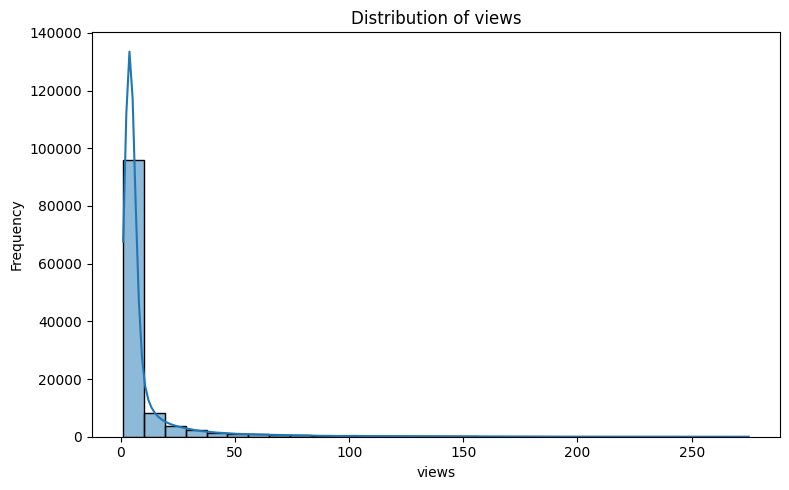

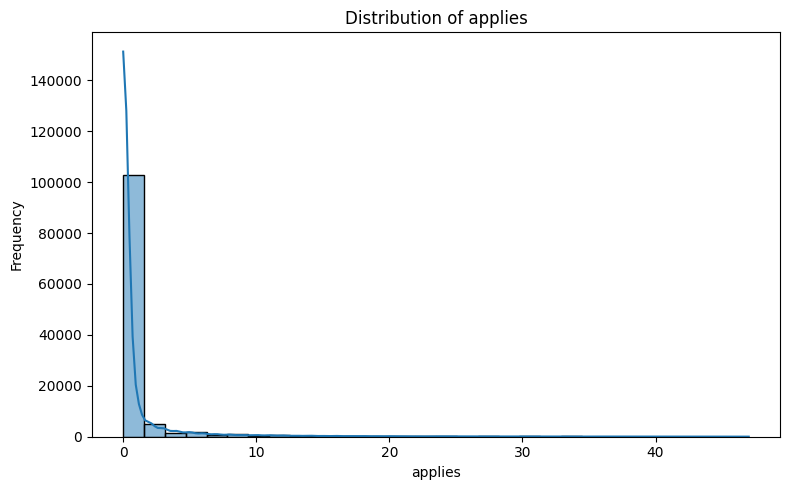

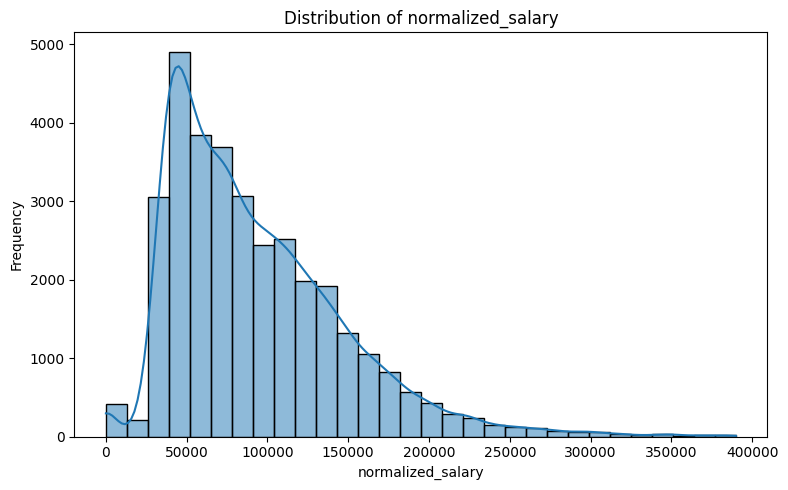

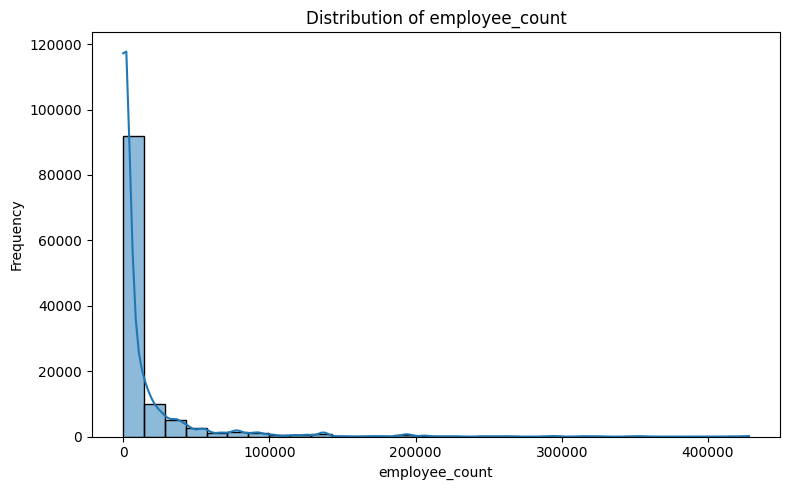

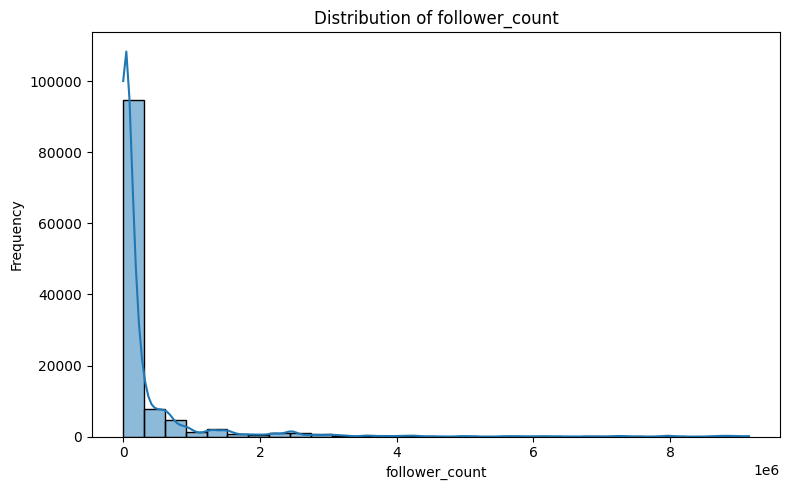

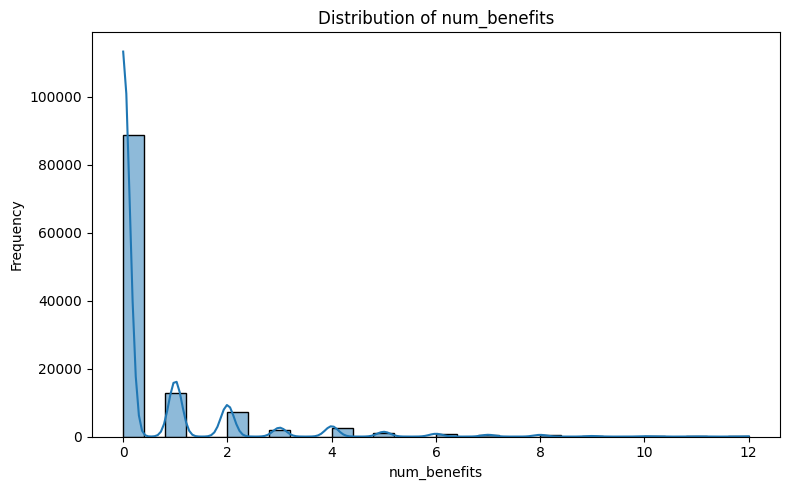

In [0]:
# Distribution plots
for var in numerical_vars:
    plt.figure(figsize=(8, 5))
    sns.histplot(final_compiled_clean_no_outliers[var], kde=True, bins=30)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


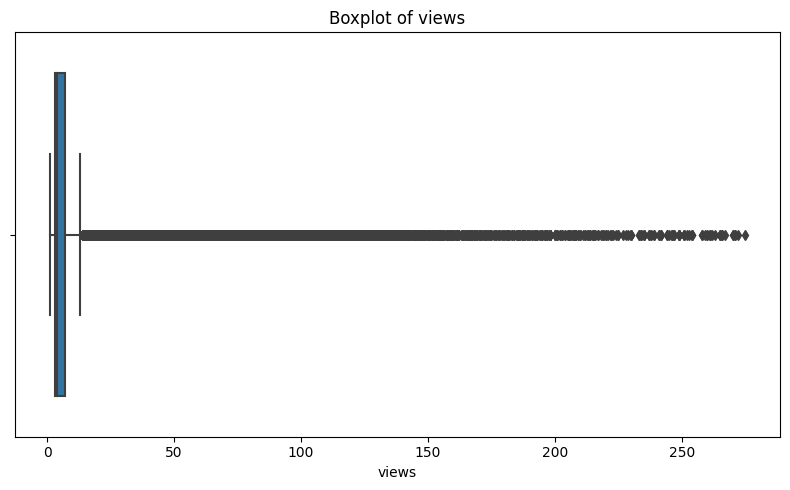

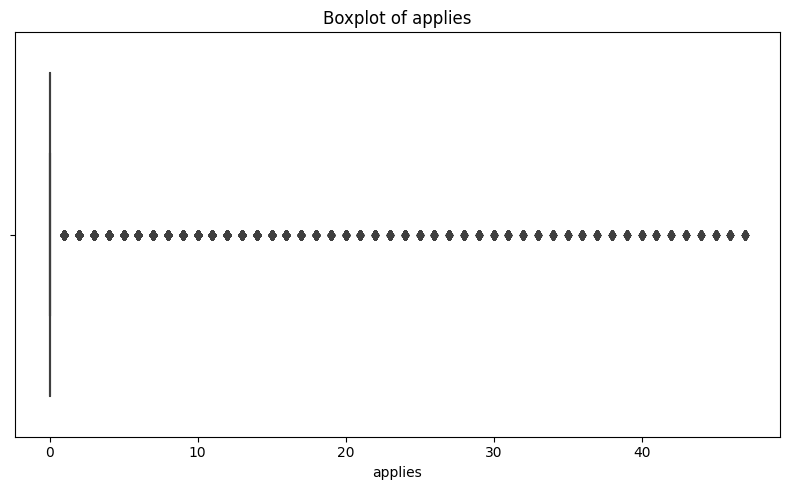

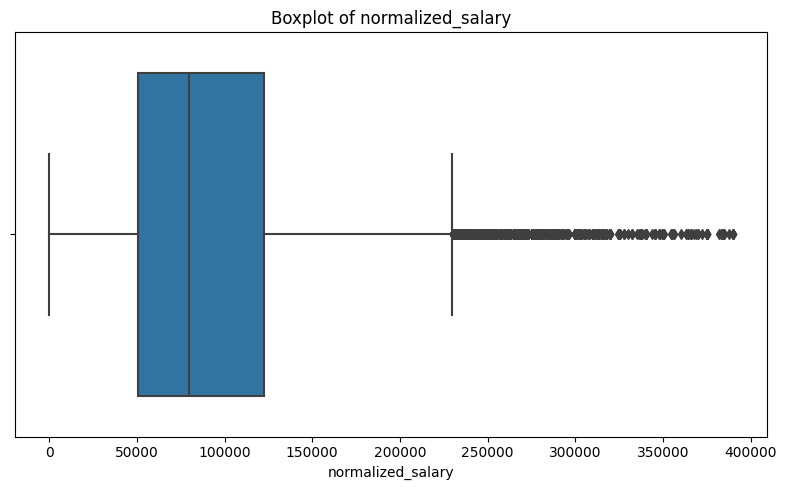

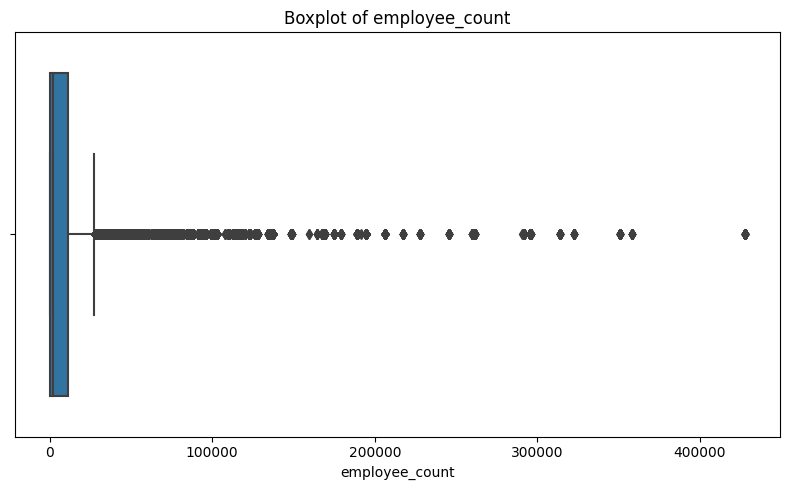

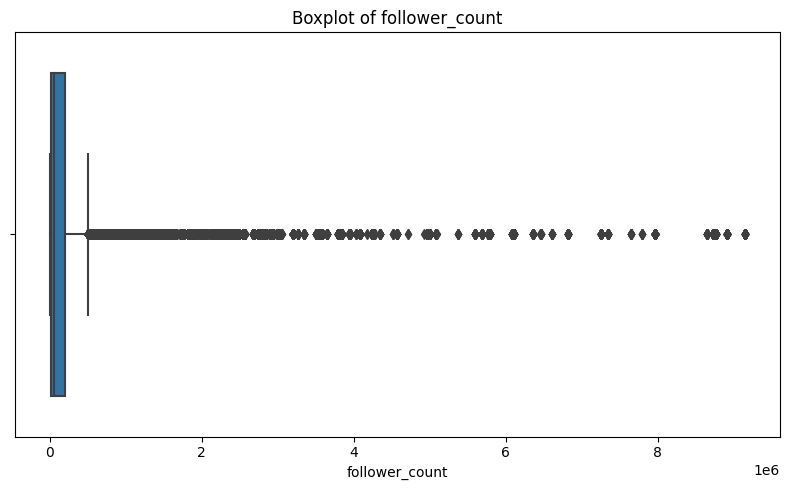

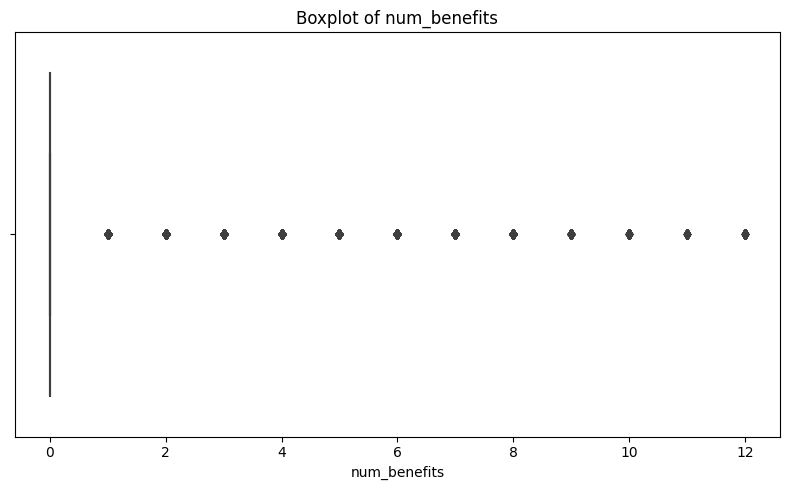

In [0]:
# Boxplots for each variable
for var in numerical_vars:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=final_compiled_clean_no_outliers, x=var)
    plt.title(f'Boxplot of {var}')
    plt.xlabel(var)
    plt.tight_layout()
    plt.show()


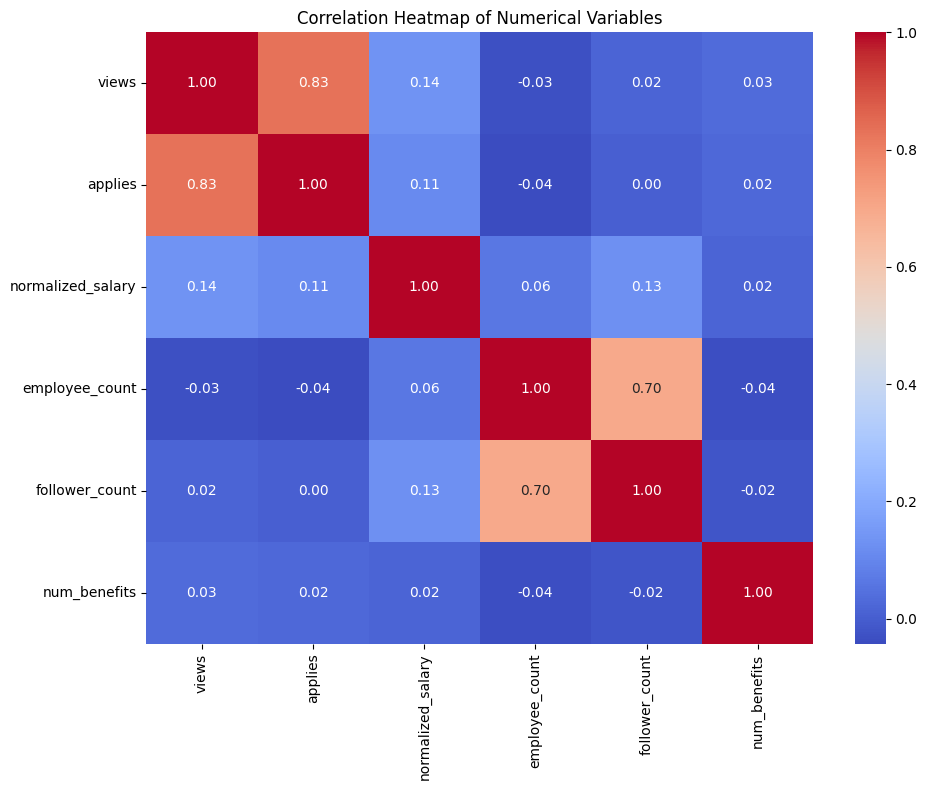

In [0]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(final_compiled_clean_no_outliers[numerical_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.tight_layout()
plt.show()


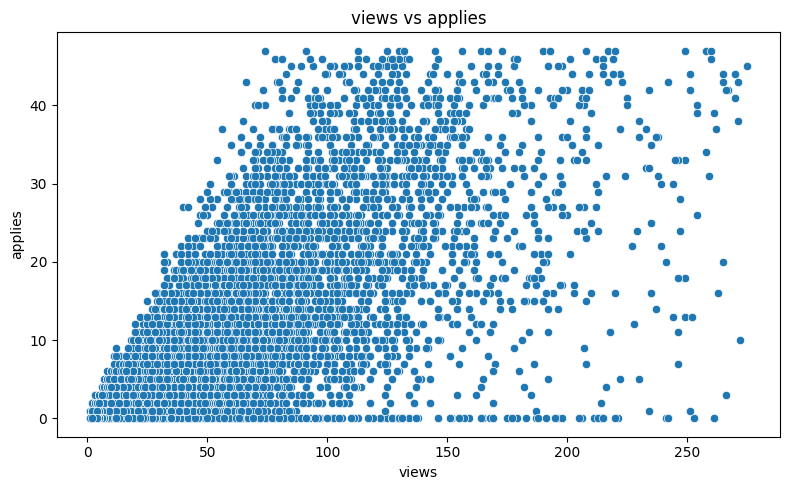

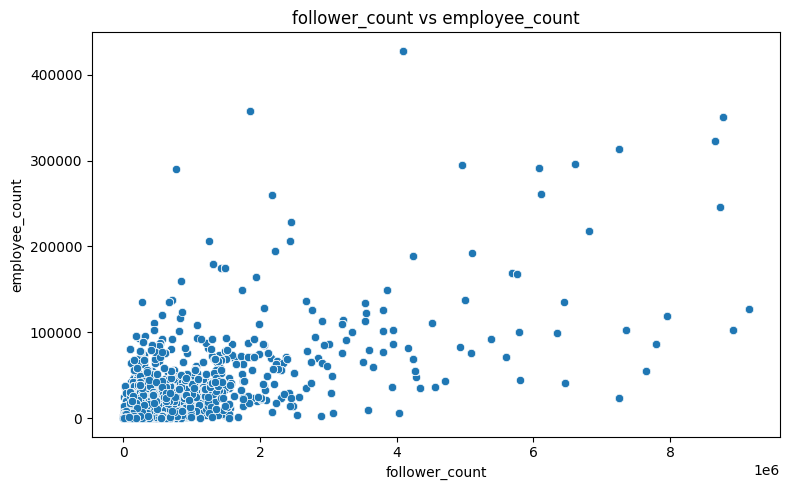

In [0]:
# Scatterplots
pairs = [('views', 'applies'), ('follower_count', 'employee_count')]

for x_var, y_var in pairs:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=final_compiled_clean_no_outliers, x=x_var, y=y_var)
    plt.title(f'{x_var} vs {y_var}')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.tight_layout()
    plt.show()


#### Distributions of dummy variables

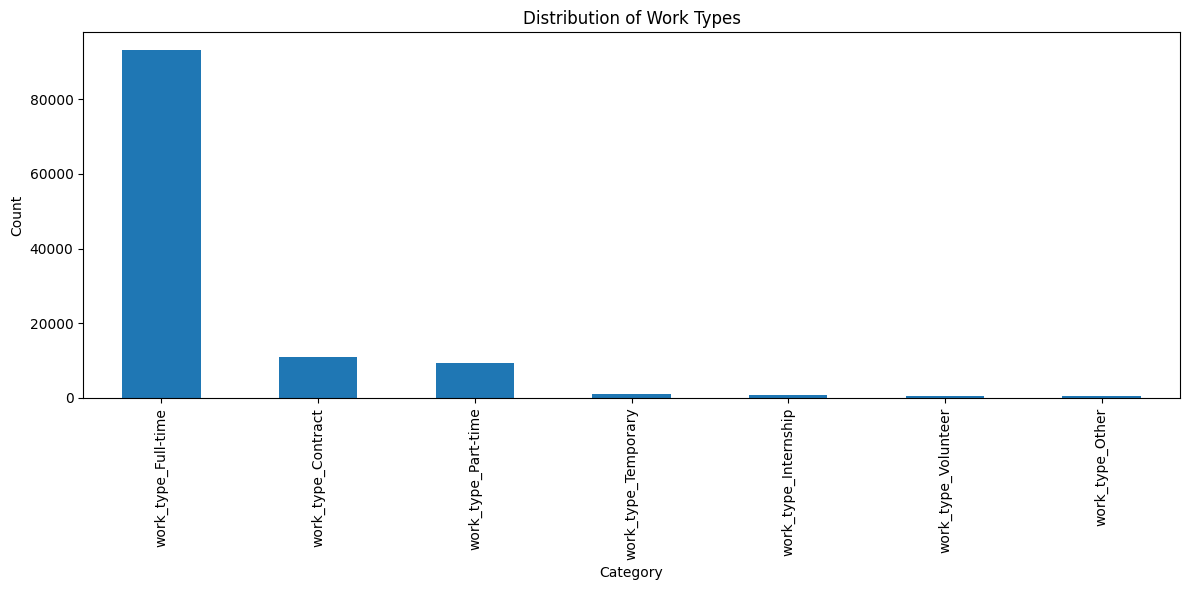

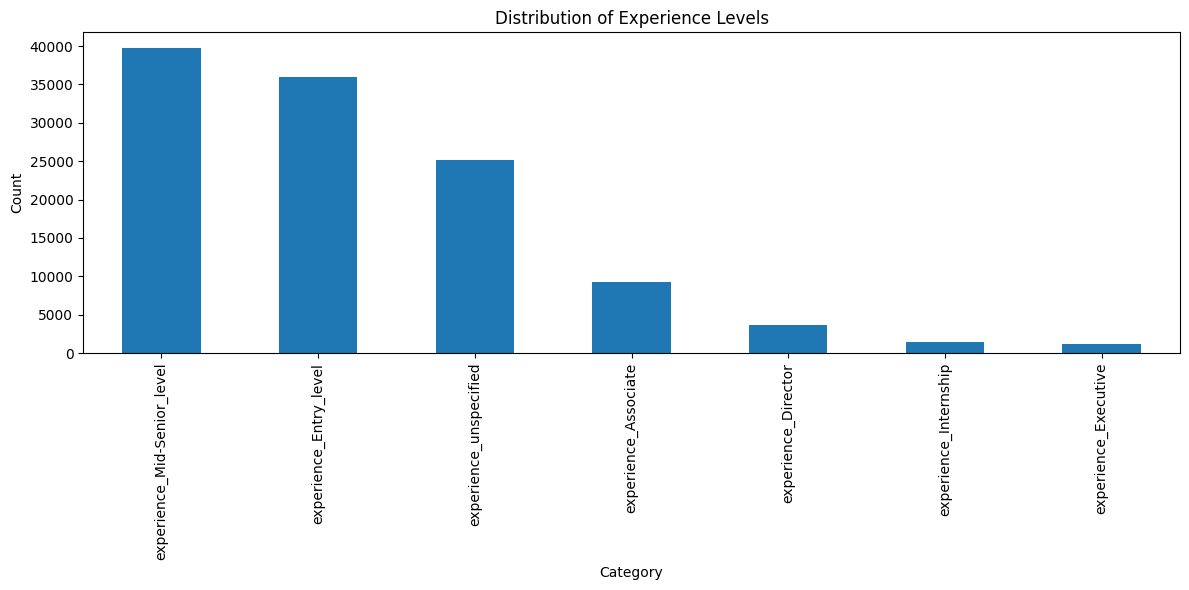

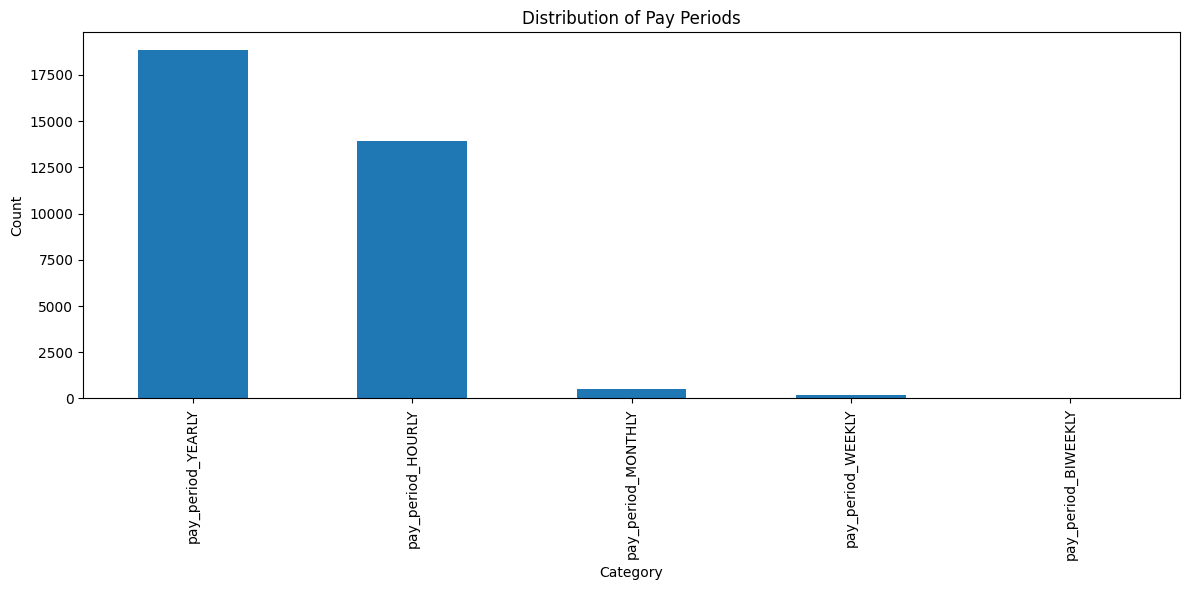

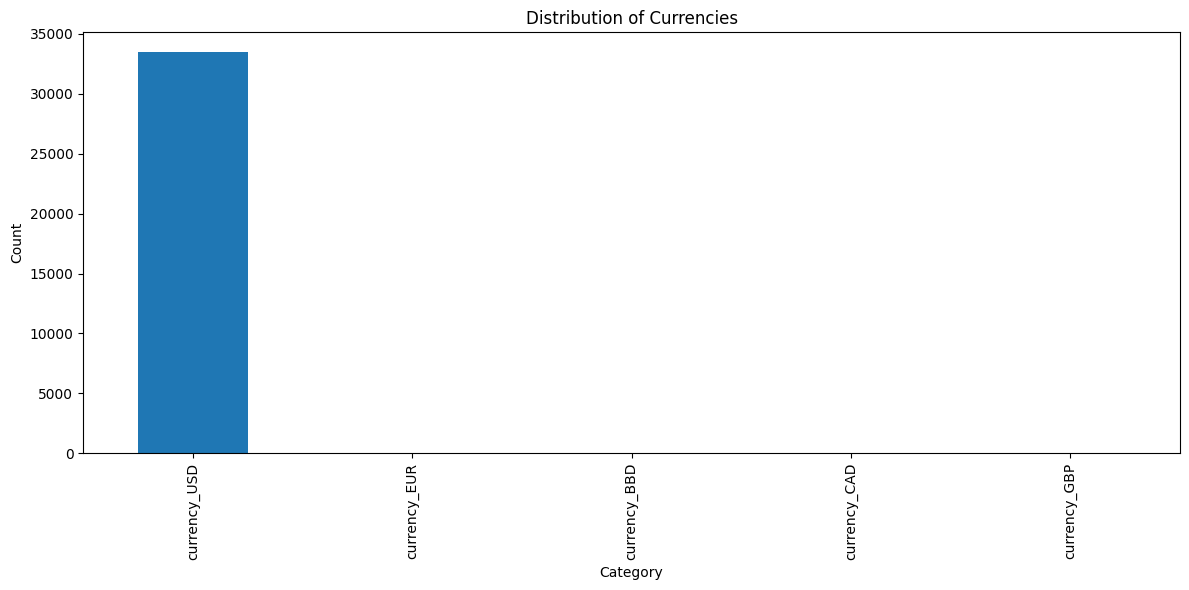

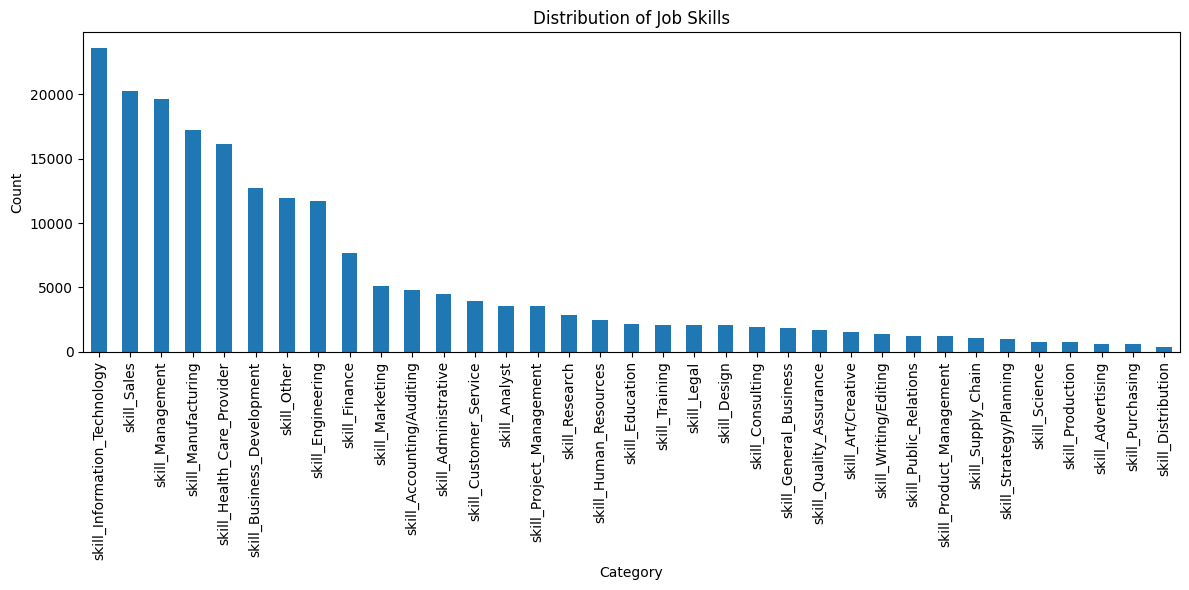

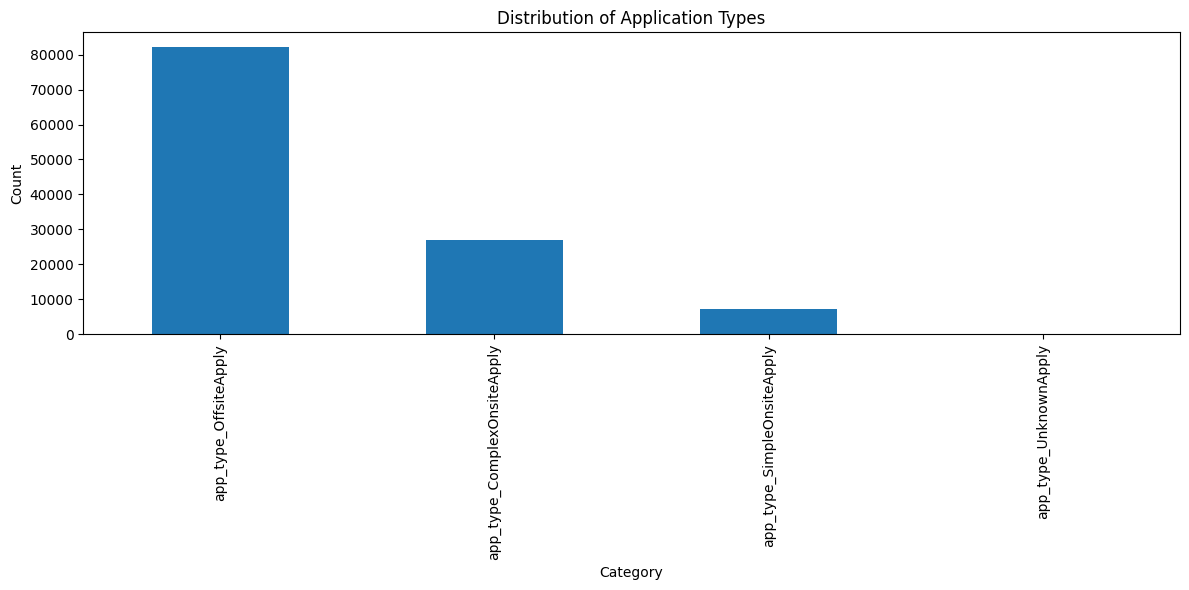

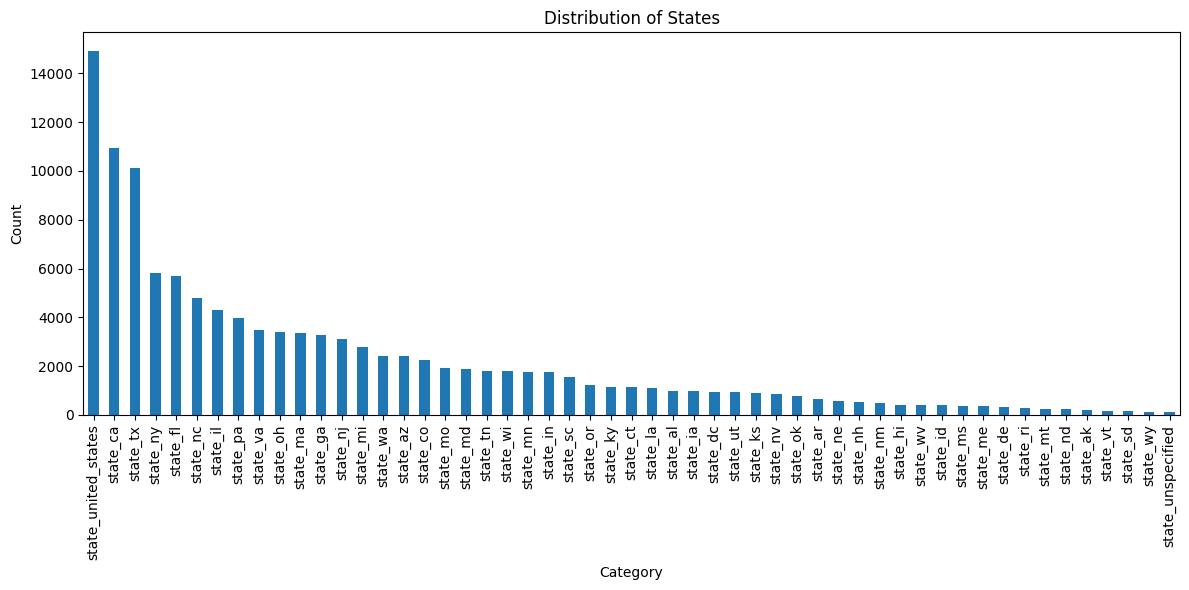

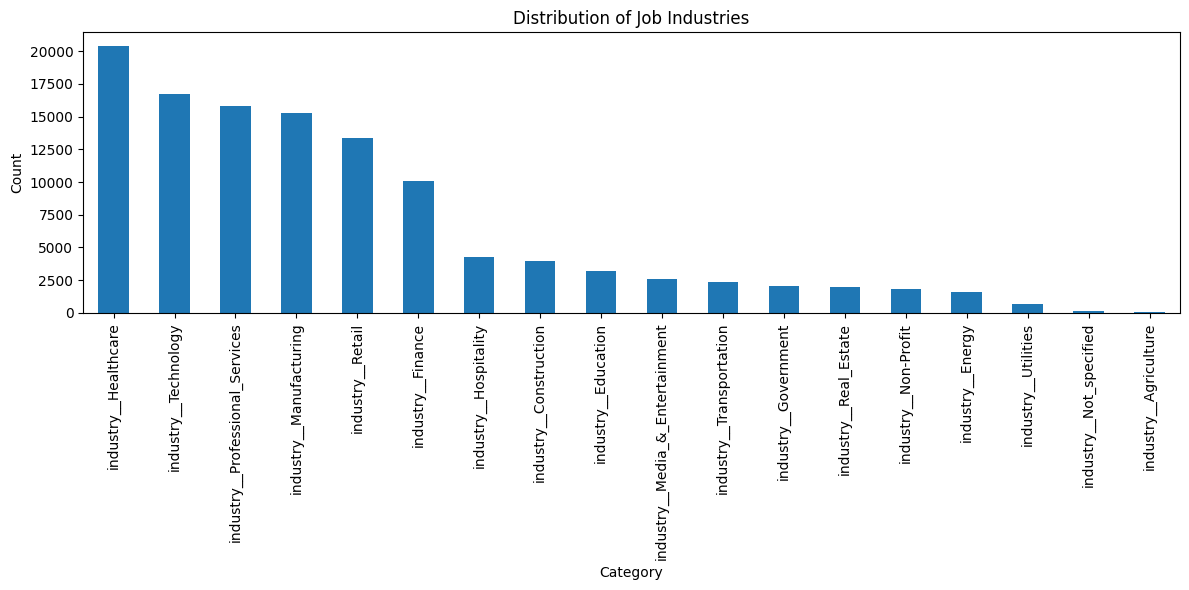

In [0]:
import matplotlib.pyplot as plt

# Function to plot distribution of dummy variables for a given prefix
def plot_dummy_distribution(df, prefix, title):
    # Select columns that start with the given prefix
    dummy_columns = [col for col in df.columns if col.startswith(prefix)]
    # Sum occurrences for each dummy variable
    distribution = df[dummy_columns].sum().sort_values(ascending=False)
    
    # Plot the distribution
    plt.figure(figsize=(12, 6))
    distribution.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Plot for work_type_* variables
plot_dummy_distribution(final_compiled_clean_no_outliers, 'work_type_', 'Distribution of Work Types')

# Plot for experience_* variables
plot_dummy_distribution(final_compiled_clean_no_outliers, 'experience_', 'Distribution of Experience Levels')

# Plot for pay_period_* variables
plot_dummy_distribution(final_compiled_clean_no_outliers, 'pay_period_', 'Distribution of Pay Periods')

# Plot for currency_* variables
plot_dummy_distribution(final_compiled_clean_no_outliers, 'currency_', 'Distribution of Currencies')

# Plot for skill_* variables
plot_dummy_distribution(final_compiled_clean_no_outliers, 'skill_', 'Distribution of Job Skills')

# Plot for app_type_* variables
plot_dummy_distribution(final_compiled_clean_no_outliers, 'app_type_', 'Distribution of Application Types')

# Plot for state_* variables
plot_dummy_distribution(final_compiled_clean_no_outliers, 'state_', 'Distribution of States')

# Plot for industry__* variables
plot_dummy_distribution(final_compiled_clean_no_outliers, 'industry__', 'Distribution of Job Industries')


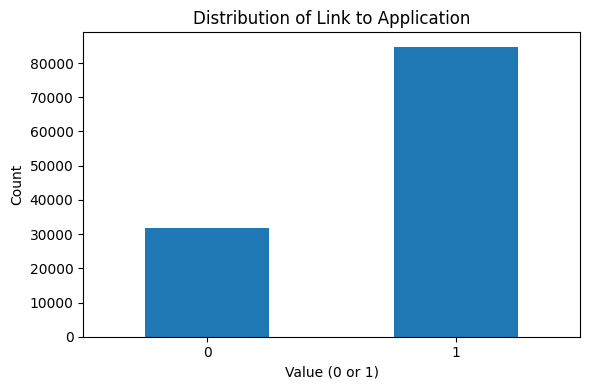

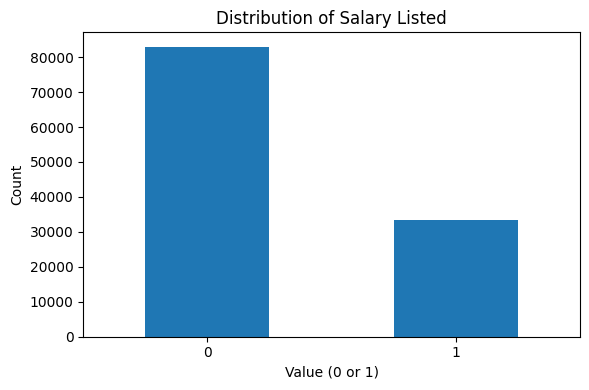

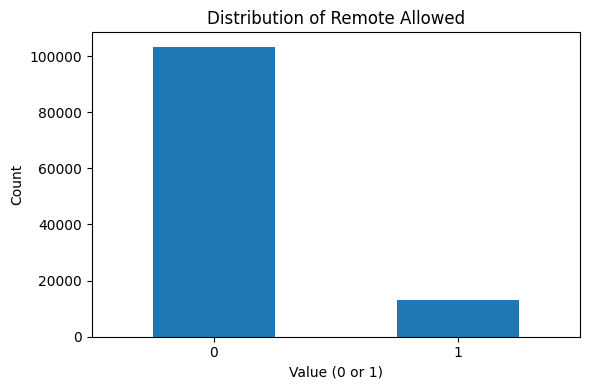

In [0]:
# Function to plot distribution for single-column dummy variables
def plot_single_dummy_distribution(df, column_name, title):
    # Get counts of 0s and 1s
    distribution = df[column_name].value_counts().sort_index()
    
    # Plot the distribution
    plt.figure(figsize=(6, 4))
    distribution.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Value (0 or 1)')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
    plt.tight_layout()
    plt.show()

# Plot for link_to_application
plot_single_dummy_distribution(final_compiled_clean_no_outliers, 'link_to_application', 'Distribution of Link to Application')

# Plot for salary_listed
plot_single_dummy_distribution(final_compiled_clean_no_outliers, 'salary_listed', 'Distribution of Salary Listed')

# Plot for remote_allowed
plot_single_dummy_distribution(final_compiled_clean_no_outliers, 'remote_allowed', 'Distribution of Remote Allowed')


#### Median normalized_salary and mean views by dummy variable category

Generating plots for prefix: skill_


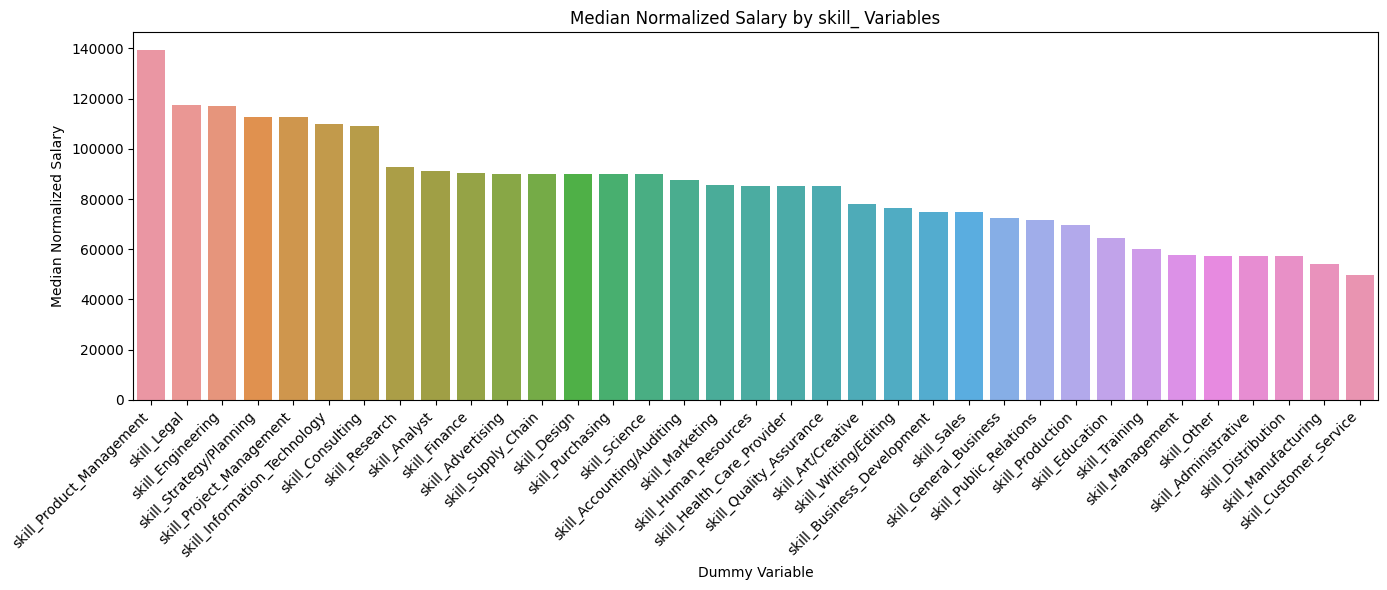

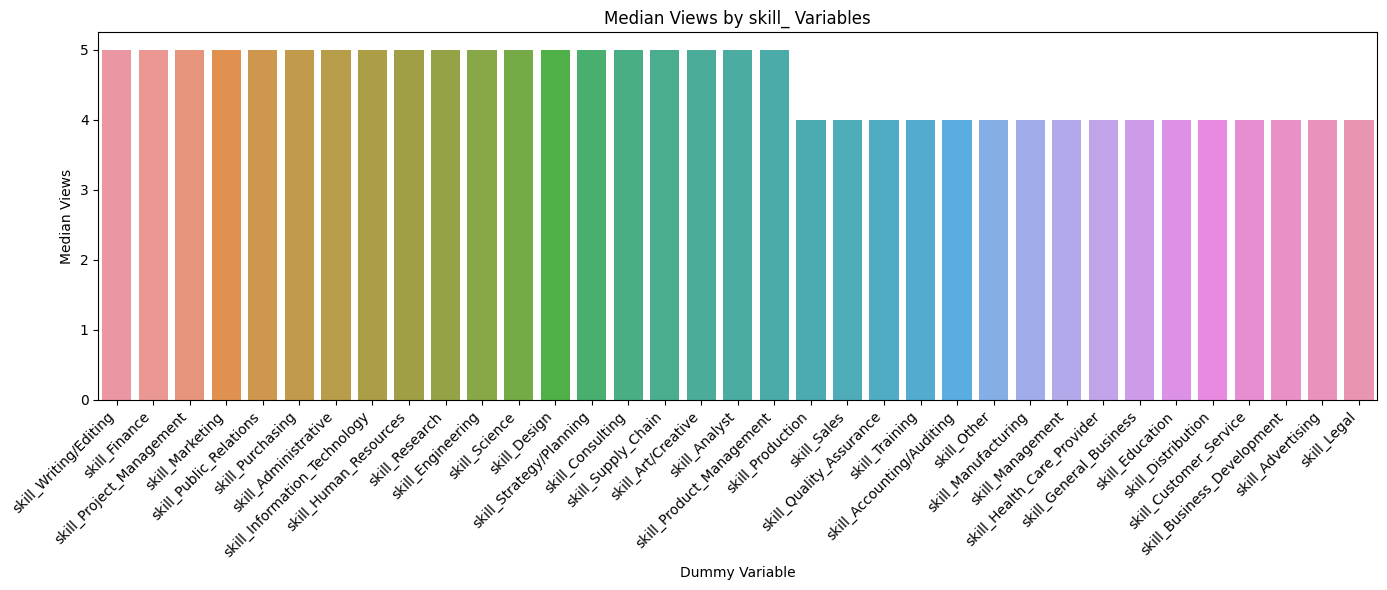

Generating plots for prefix: state_


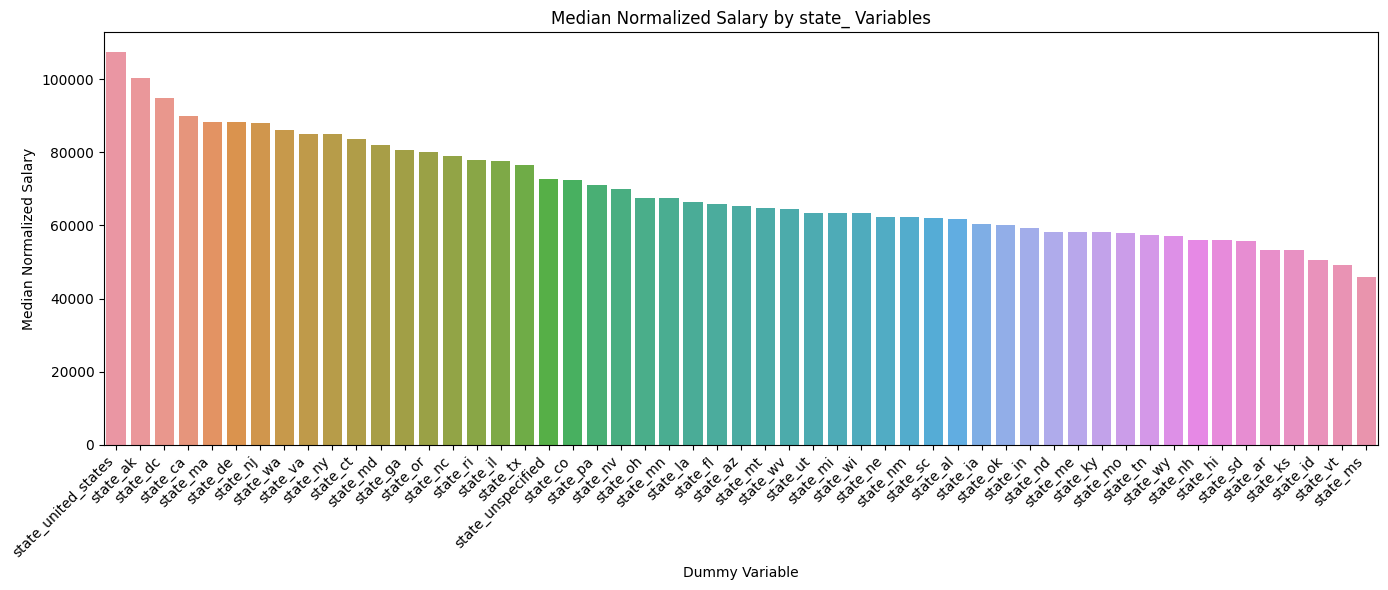

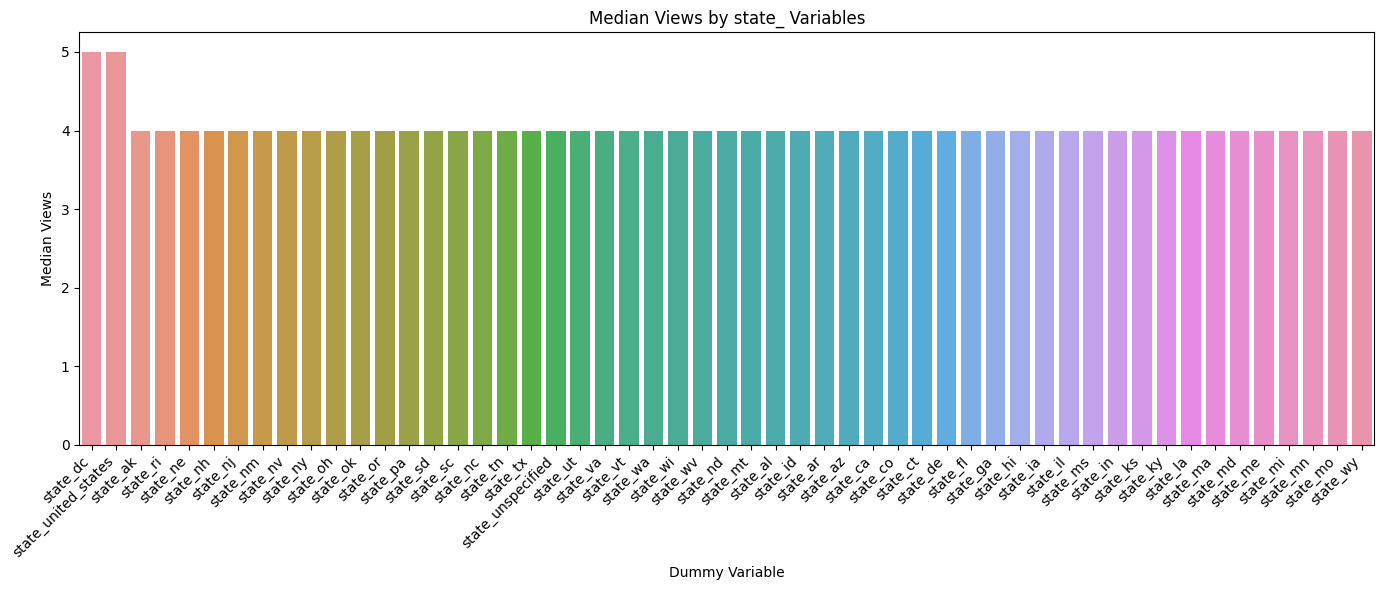

Generating plots for prefix: industry_


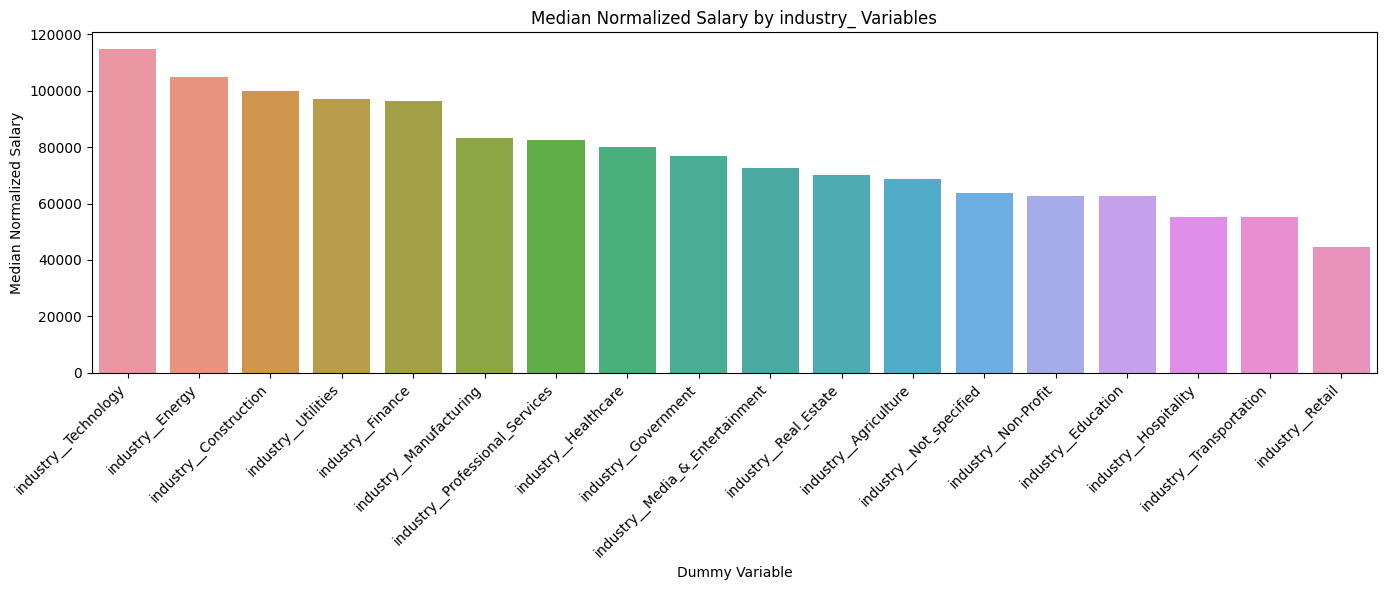

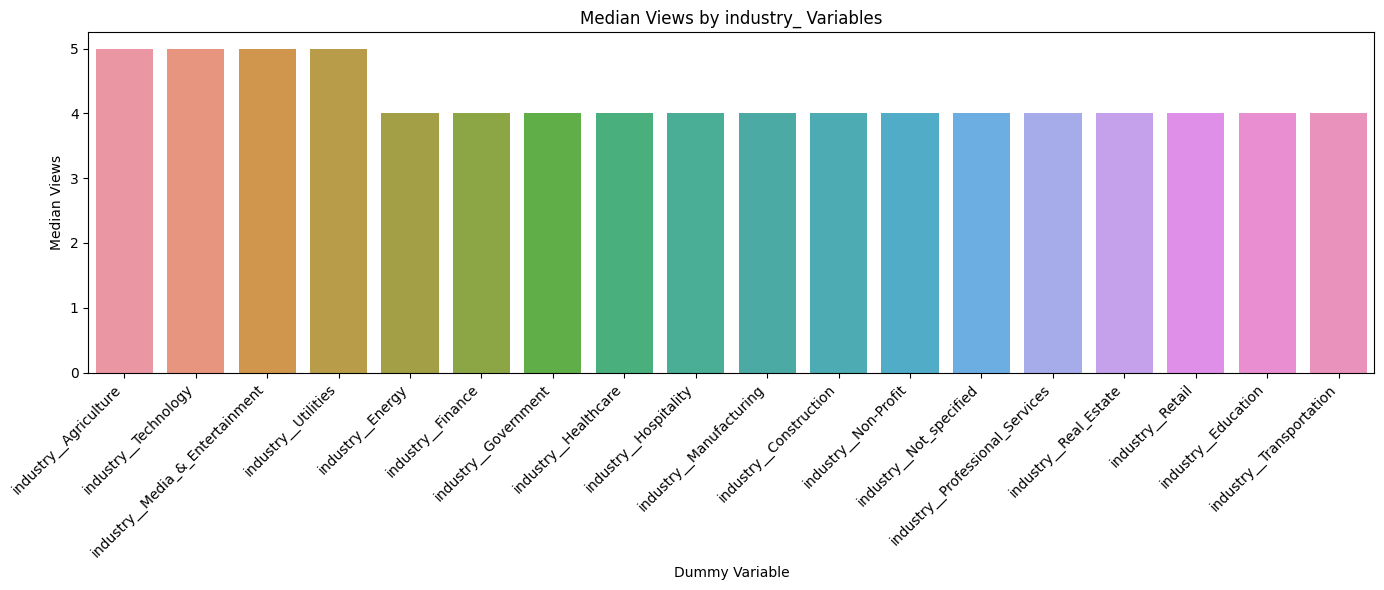

Generating plots for prefix: work_type_


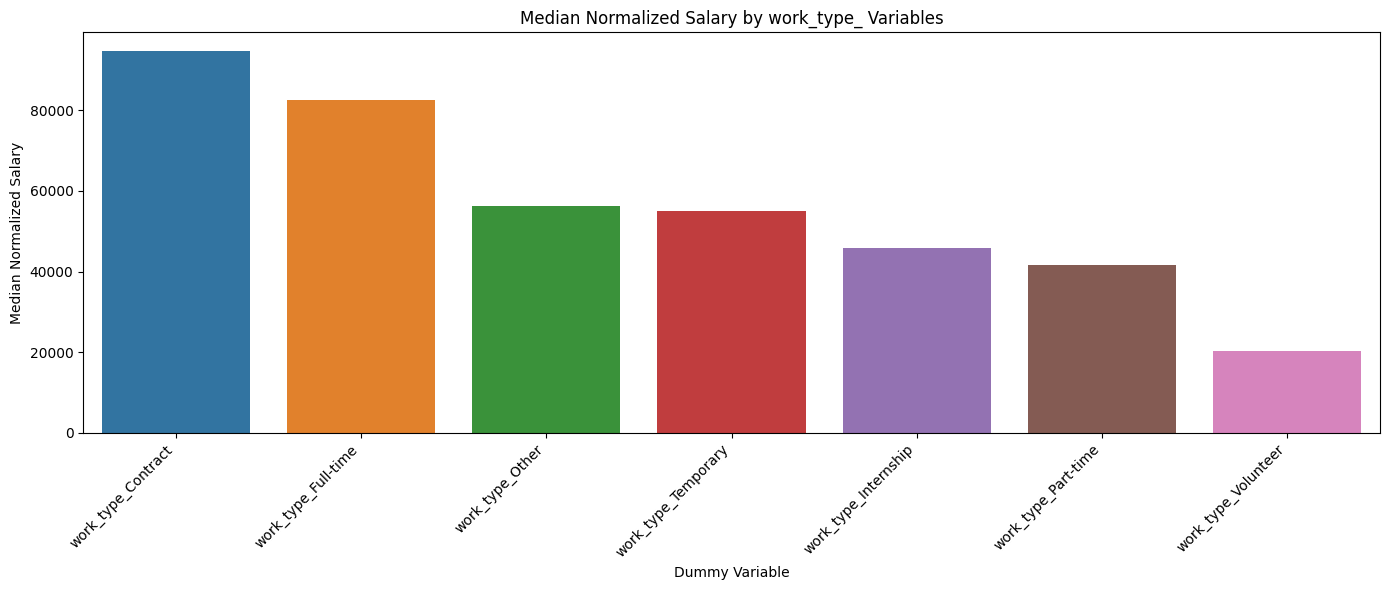

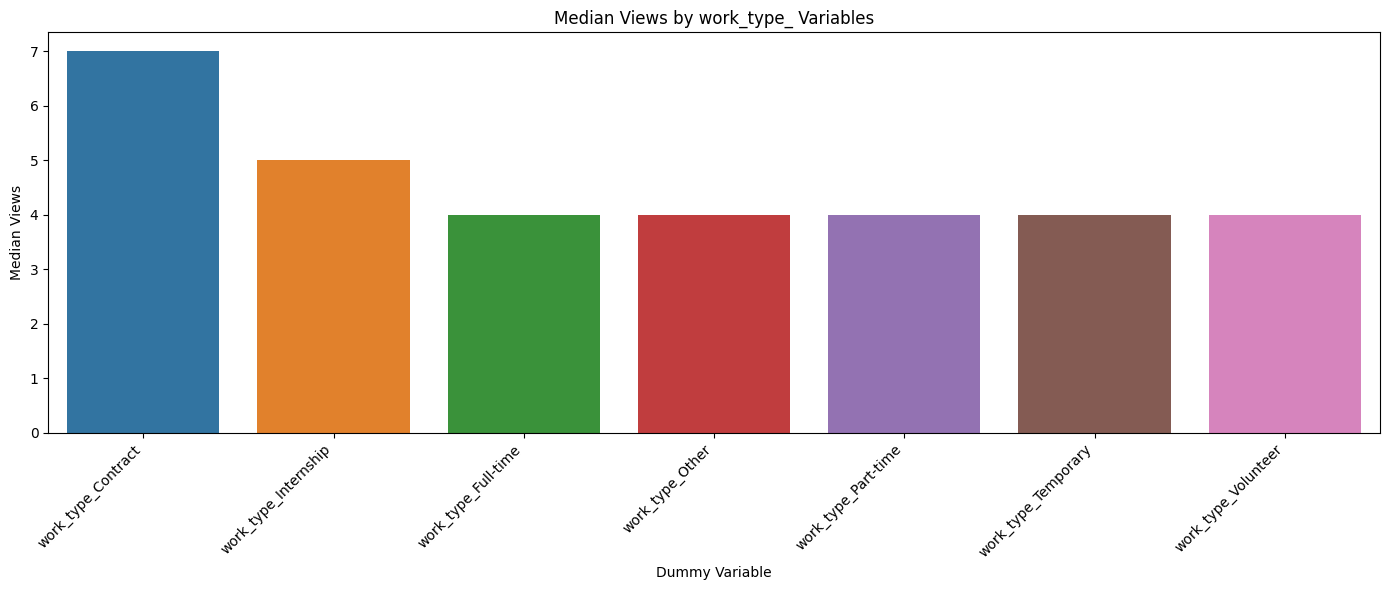

Generating plots for prefix: experience_


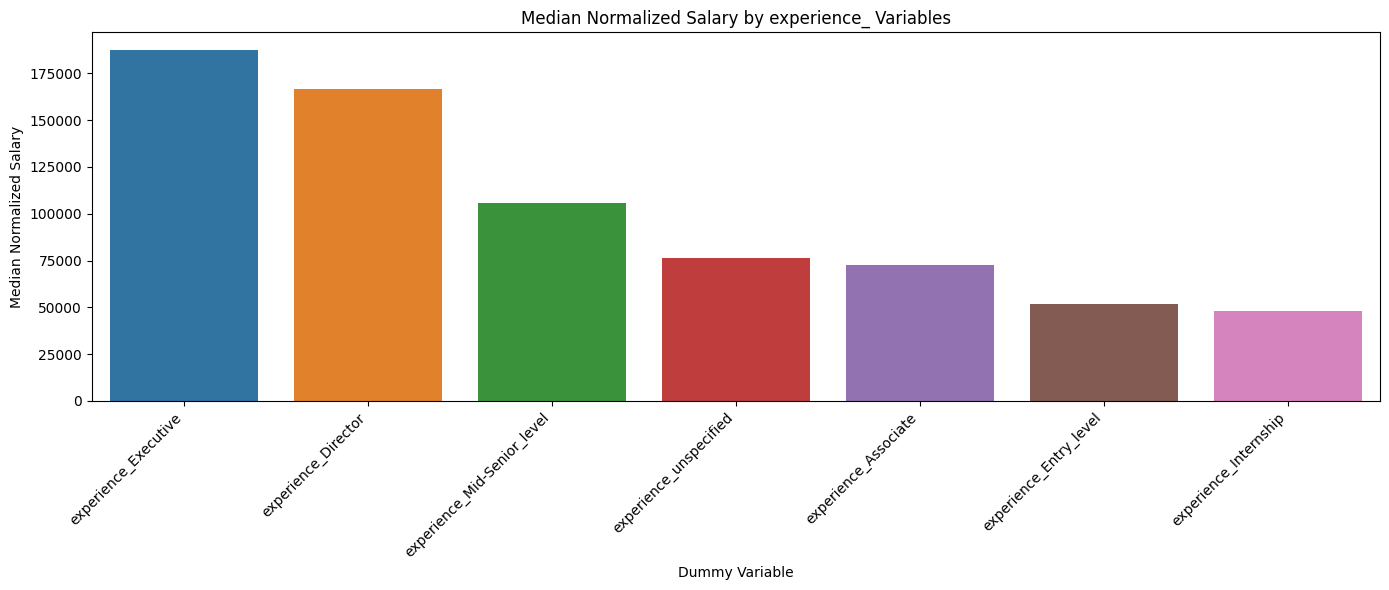

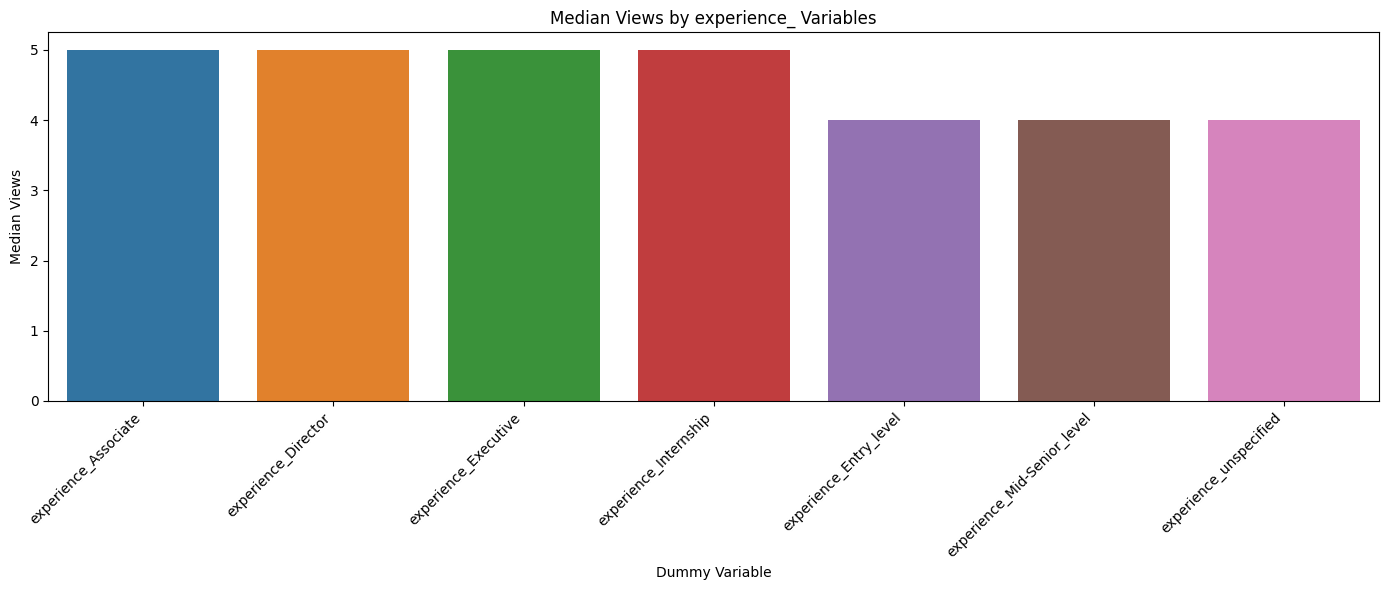

Generating plots for prefix: pay_period_


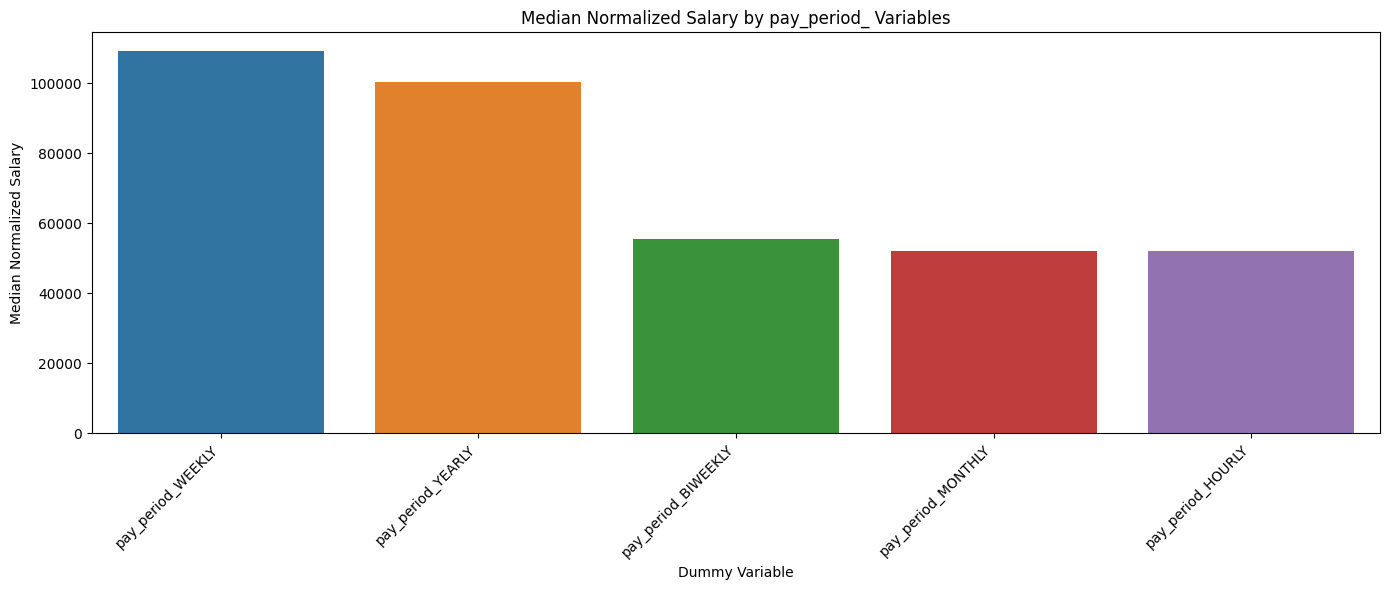

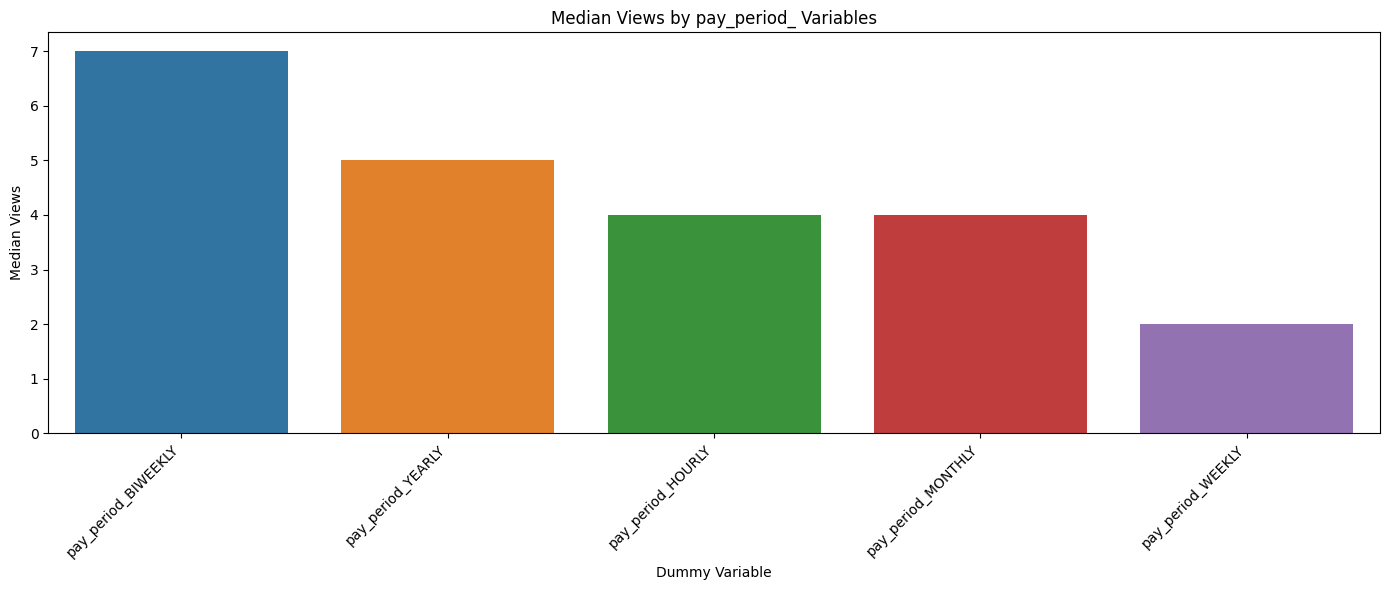

Generating plots for prefix: currency_


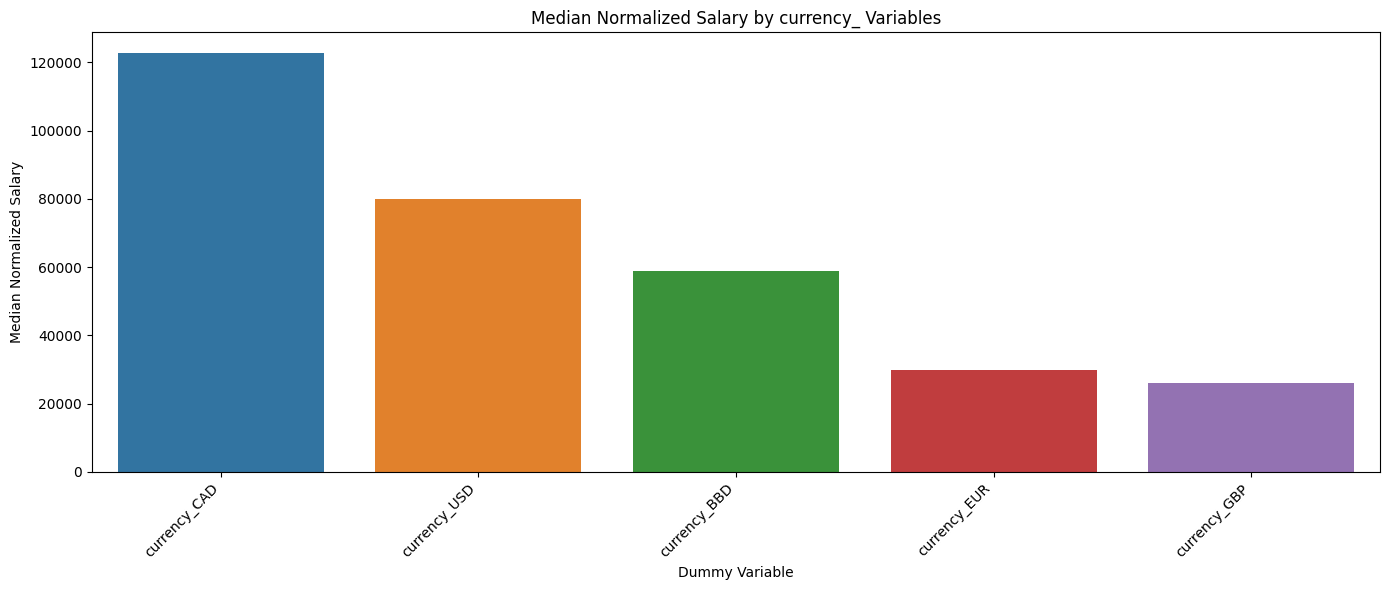

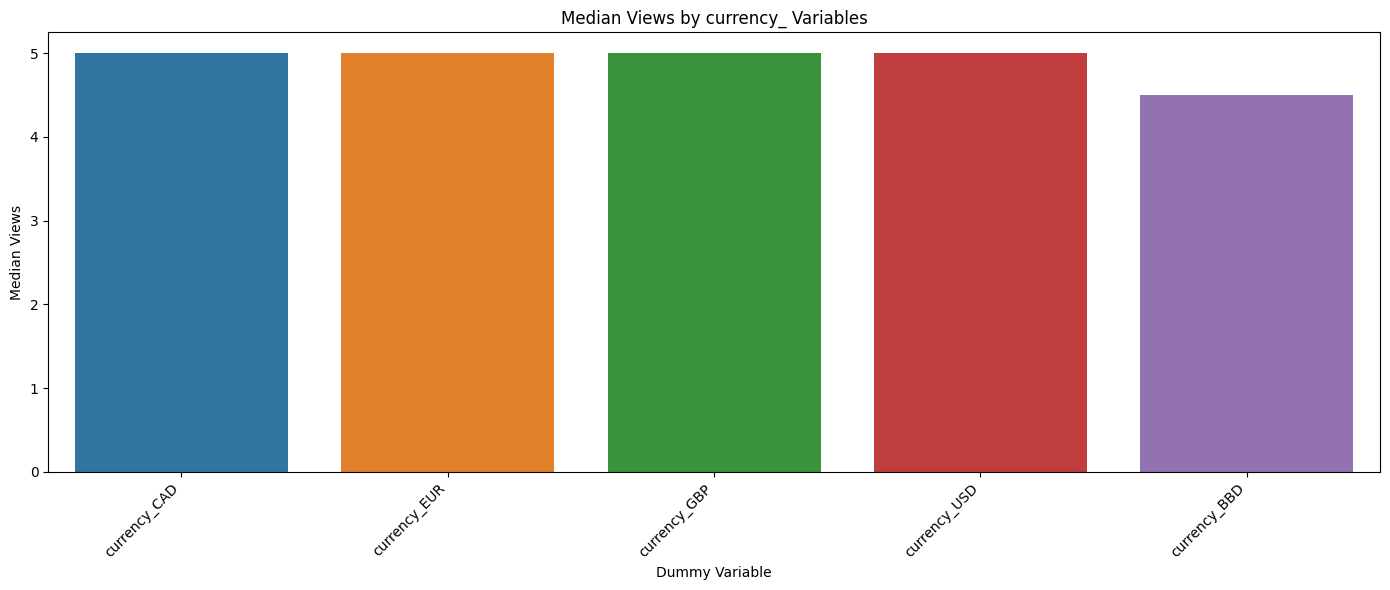

Generating plots for prefix: app_type_


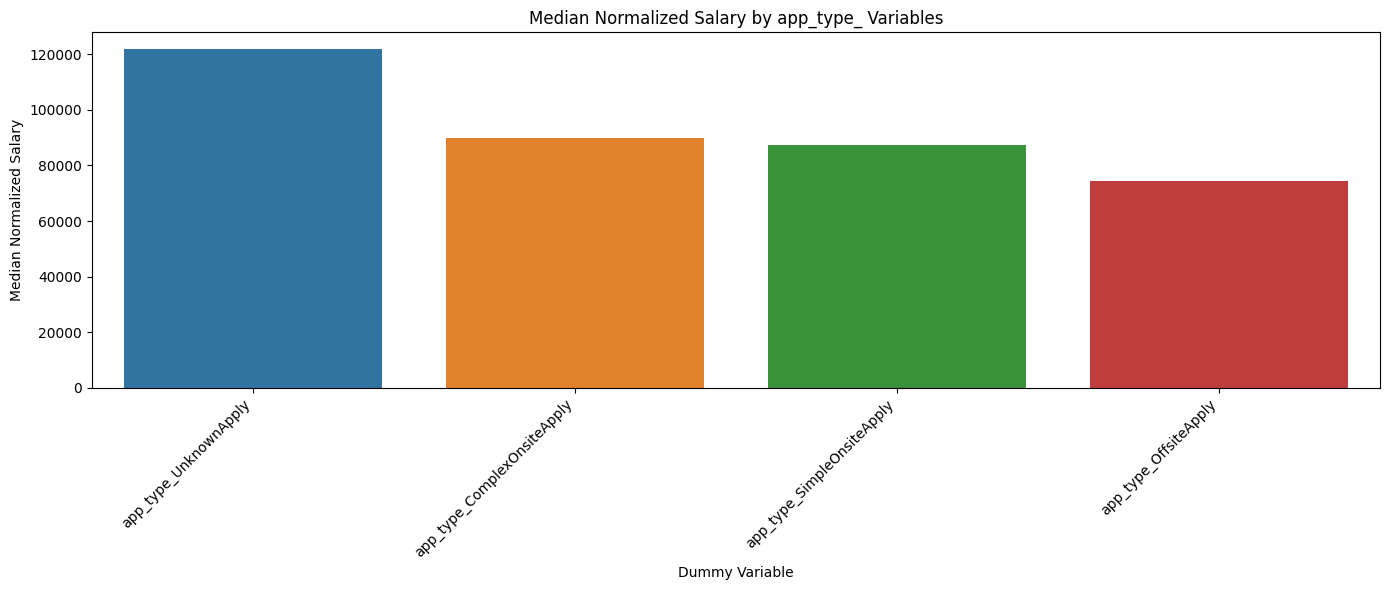

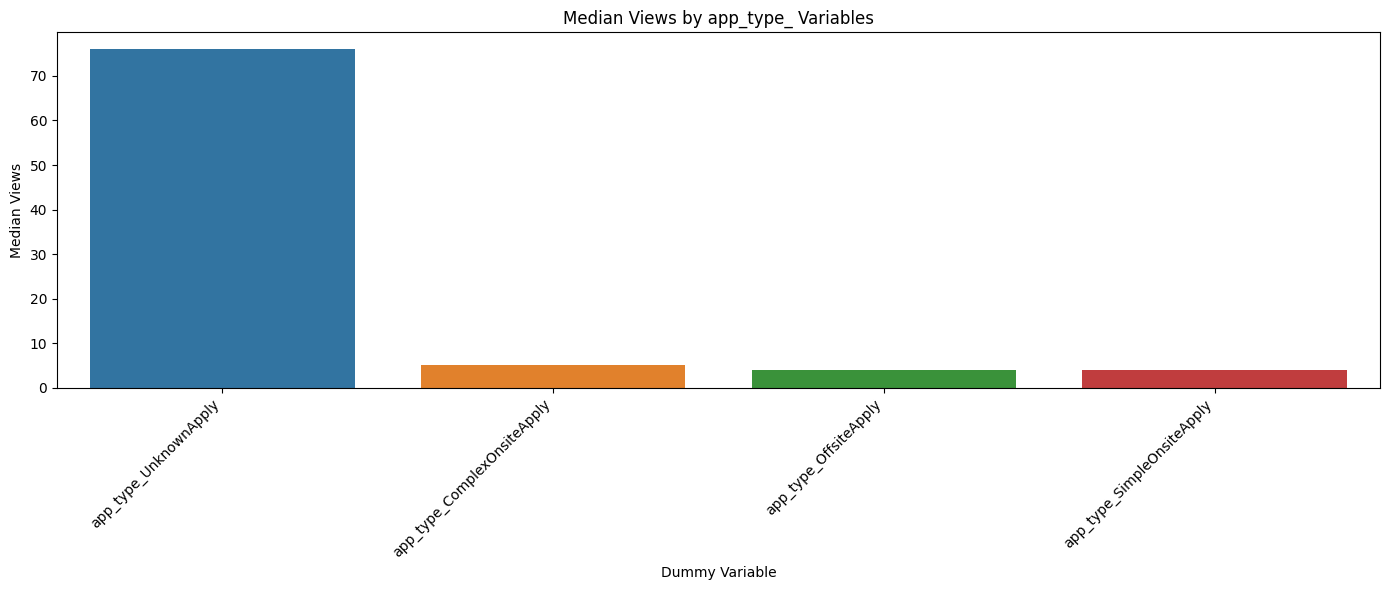

In [0]:
# Function to create two bar plots for each prefix group using median
def plot_metric_by_prefix_group(df, prefix):
    # Get all columns that start with the given prefix
    columns_with_prefix = [col for col in df.columns if col.startswith(prefix)]
    
    # Melt the DataFrame to create a tidy format
    melted_df = df.melt(id_vars=['normalized_salary', 'views'], 
                        value_vars=columns_with_prefix, 
                        var_name='dummy_variable', 
                        value_name='is_active')
    
    # Filter rows where the dummy variable is active (value == 1)
    active_df = melted_df[melted_df['is_active'] == 1]
    
    # Calculate the median metrics for each dummy variable
    salary_median = active_df.groupby('dummy_variable')['normalized_salary'].median().sort_values(ascending=False)
    views_mean = active_df.groupby('dummy_variable')['views'].mean().sort_values(ascending=False)
    views_median = active_df.groupby('dummy_variable')['views'].median().sort_values(ascending=False)
    
    # Plot median normalized_salary
    plt.figure(figsize=(14, 6))
    sns.barplot(x=salary_median.index, y=salary_median.values)
    plt.title(f'Median Normalized Salary by {prefix} Variables')
    plt.xlabel('Dummy Variable')
    plt.ylabel('Median Normalized Salary')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Plot median views
    plt.figure(figsize=(14, 6))
    sns.barplot(x=views_median.index, y=views_median.values)
    plt.title(f'Median Views by {prefix} Variables')
    plt.xlabel('Dummy Variable')
    plt.ylabel('Median Views')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# List of prefixes to analyze
prefix_groups = ['skill_', 'state_', 'industry_', 'work_type_', 'experience_', 'pay_period_', 'currency_', 'app_type_']
for prefix in prefix_groups:
    print(f"Generating plots for prefix: {prefix}")
    plot_metric_by_prefix_group(final_compiled_clean_no_outliers, prefix)


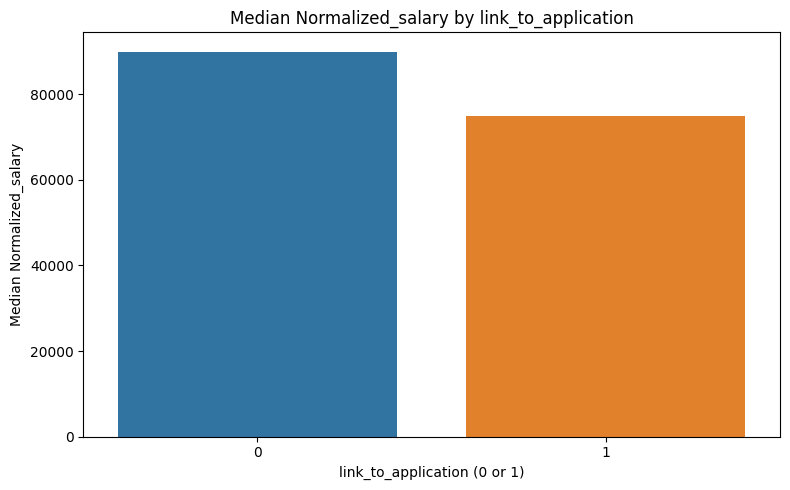

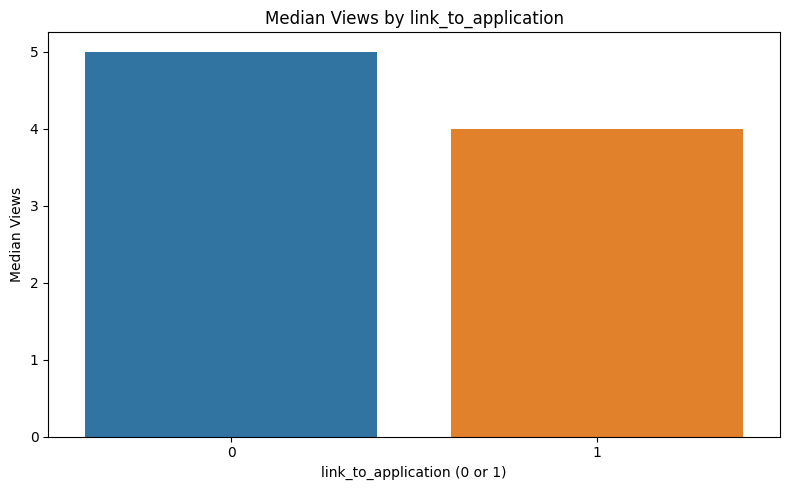

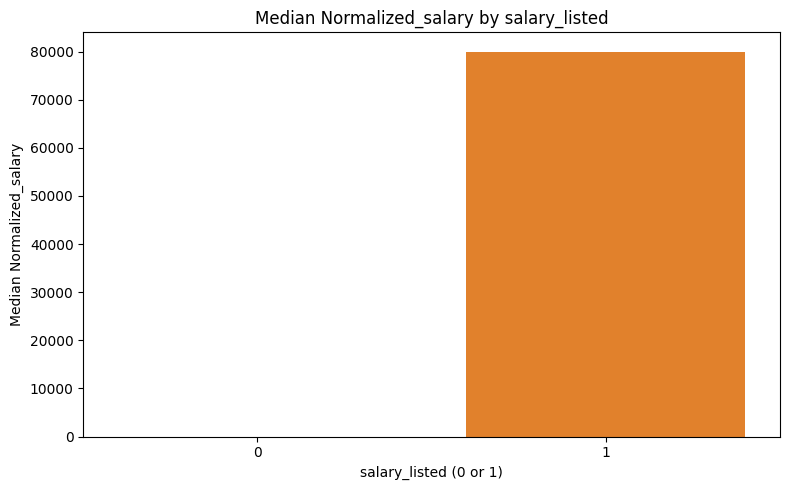

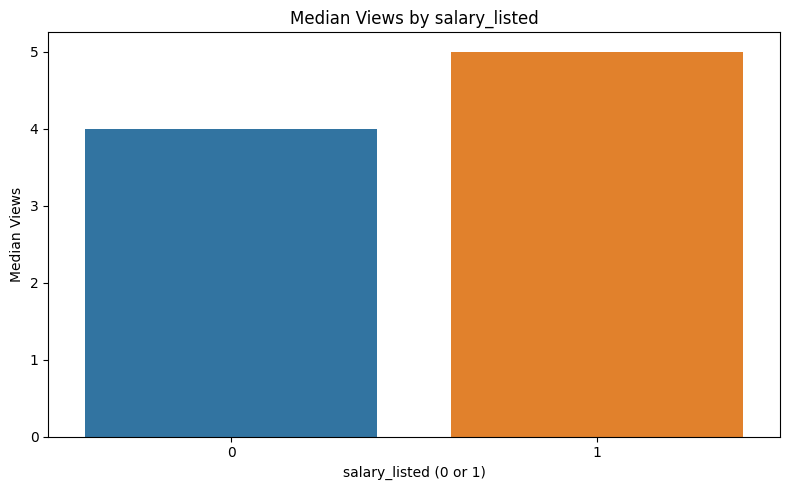

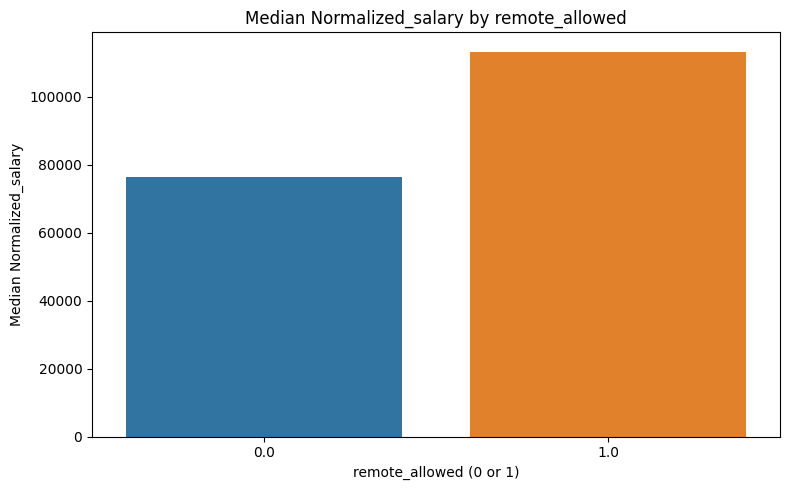

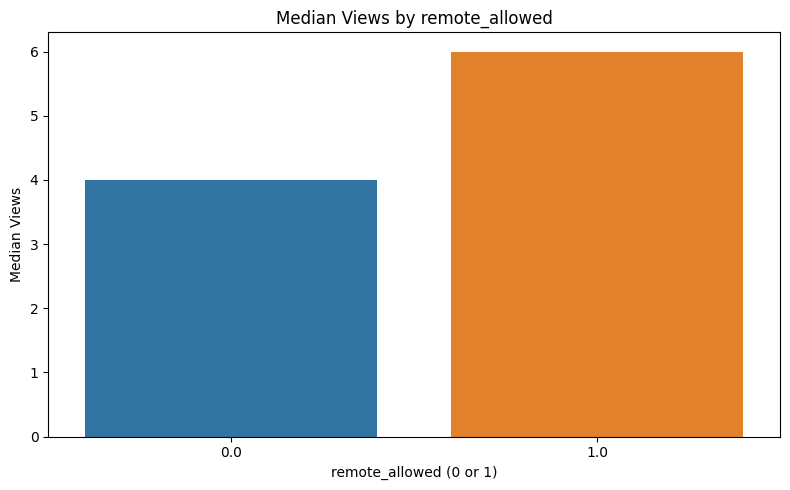

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to create separate plots for views and normalized_salary using appropriate aggregations
def plot_metric_by_column(df, column_name, metric, agg_func):
    # Calculate the aggregated metric (mean or median) grouped by the column
    aggregated = df.groupby(column_name)[metric].agg(agg_func).reset_index()
    
    # Plot using seaborn
    plt.figure(figsize=(8, 5))
    sns.barplot(data=aggregated, x=column_name, y=metric)
    plt.title(f'{agg_func.capitalize()} {metric.capitalize()} by {column_name}')
    plt.xlabel(f'{column_name} (0 or 1)')
    plt.ylabel(f'{agg_func.capitalize()} {metric.capitalize()}')
    plt.tight_layout()
    plt.show()

# Plot for each combination of column and metric with appropriate aggregation
dummy_columns = ['link_to_application', 'salary_listed', 'remote_allowed']

for column in dummy_columns:
    # Median for normalized_salary
    plot_metric_by_column(final_compiled_clean_no_outliers, column, 'normalized_salary', 'median')
    # Mean for views
    plot_metric_by_column(final_compiled_clean_no_outliers, column, 'views', 'median')

#### Postings over time

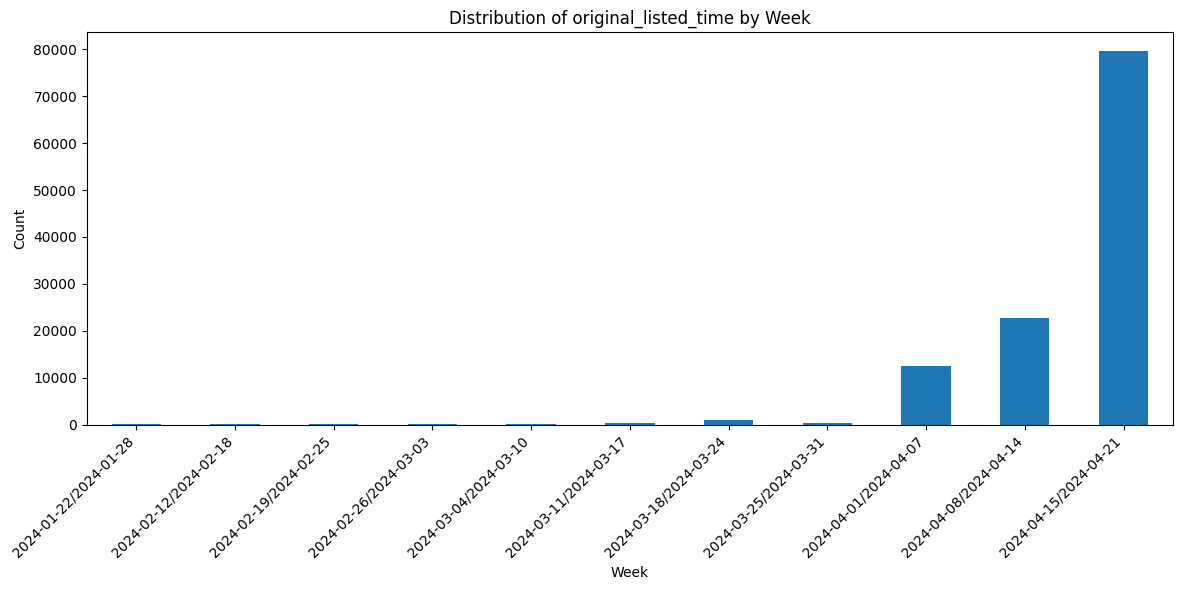

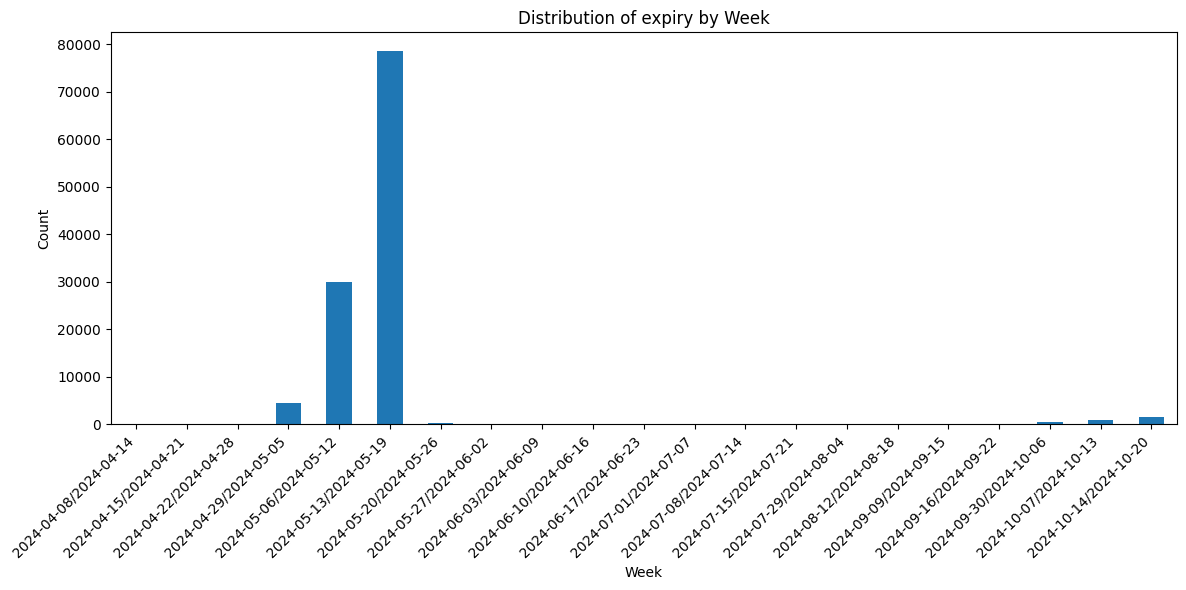

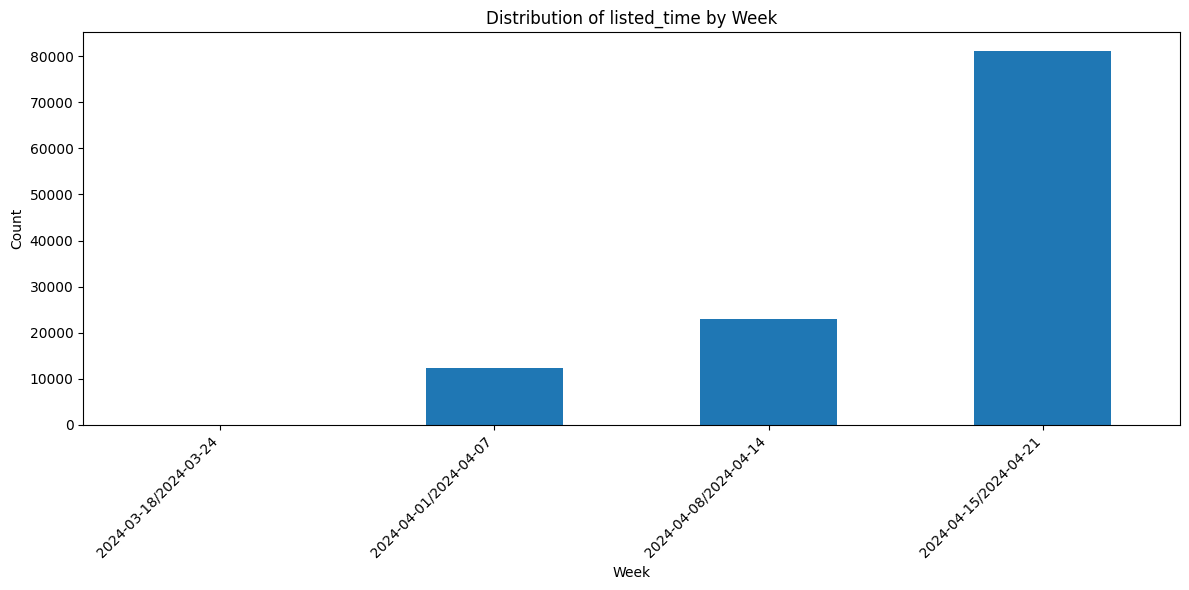

In [0]:
# Extract the week from each datetime column and count occurrences
def plot_time_distributions_by_week(df, time_columns):
    for col in time_columns:
        # Ensure the column is datetime format
        df[col] = pd.to_datetime(df[col], errors='coerce')

        # Extract week-year for aggregation
        df[f'{col}_week'] = df[col].dt.to_period('W')

        # Count occurrences by week
        weekly_counts = df[f'{col}_week'].value_counts().sort_index()

        # Plot the distribution
        plt.figure(figsize=(12, 6))
        weekly_counts.plot(kind='bar')
        plt.title(f'Distribution of {col} by Week')
        plt.xlabel('Week')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# Specify the time columns
time_columns = ['original_listed_time', 'expiry', 'listed_time']

# Call the function to generate the plots
plot_time_distributions_by_week(final_compiled_clean_no_outliers, time_columns)

#### Postings by Company

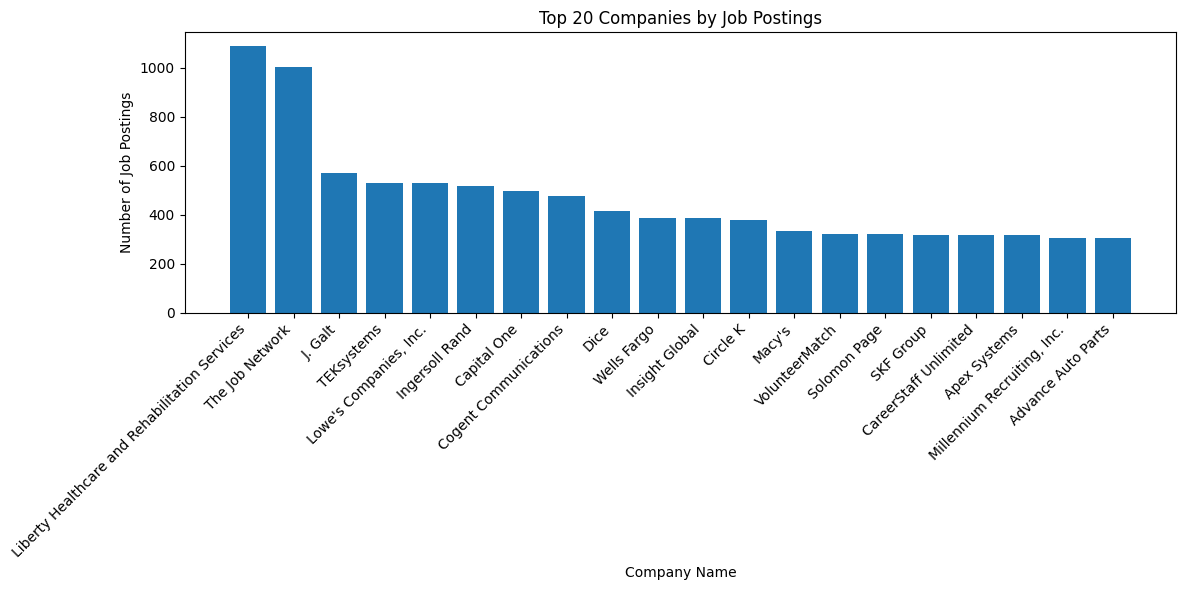

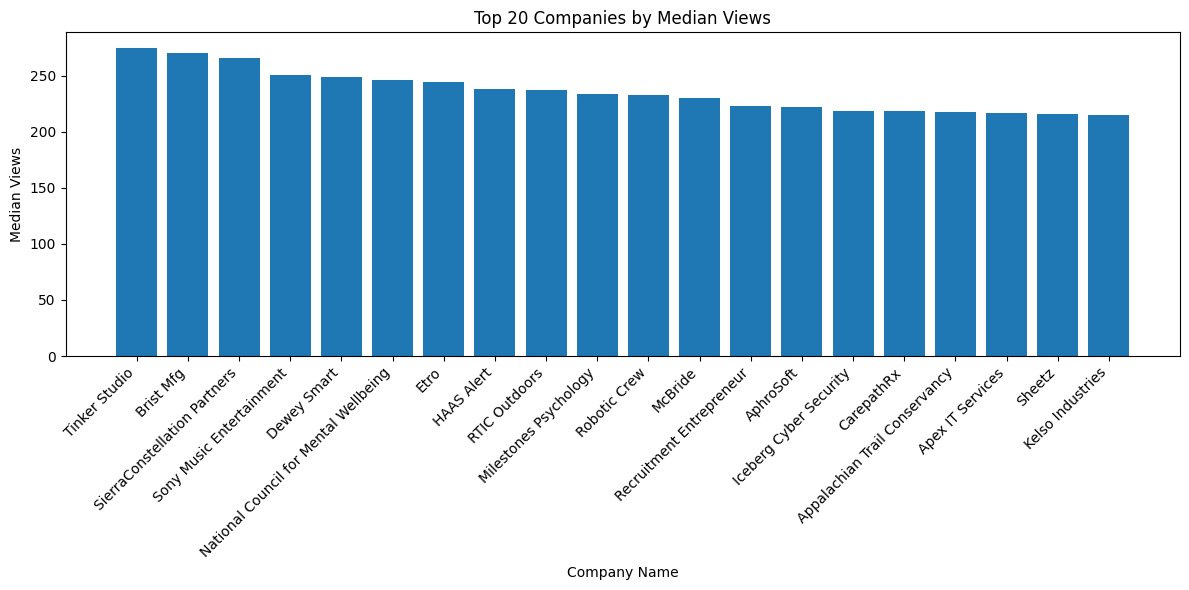

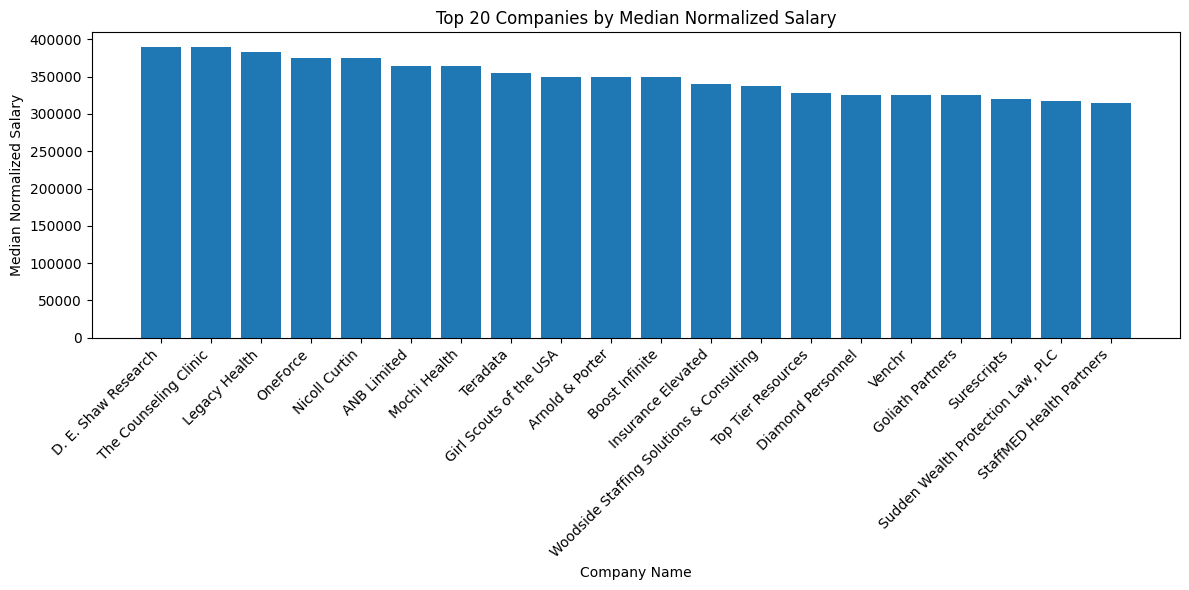

In [0]:
# Aggregate the data by company_id and calculate metrics
company_stats = final_compiled_clean_no_outliers.groupby(['company_id', 'name']).agg(
    job_postings=('company_id', 'count'),
    median_views=('views', 'median'),
    median_normalized_salary=('normalized_salary', 'median')
).reset_index()

# Sort the data for better visualization
company_stats_sorted = company_stats.sort_values(by='job_postings', ascending=False)

# Plot: Count of Job Postings by Company
plt.figure(figsize=(12, 6))
plt.bar(company_stats_sorted['name'][:20], company_stats_sorted['job_postings'][:20])
plt.title('Top 20 Companies by Job Postings')
plt.xlabel('Company Name')
plt.ylabel('Number of Job Postings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Sort by median views for visualization
company_stats_sorted_views = company_stats.sort_values(by='median_views', ascending=False)

# Plot: Median Views by Company
plt.figure(figsize=(12, 6))
plt.bar(company_stats_sorted_views['name'][:20], company_stats_sorted_views['median_views'][:20])
plt.title('Top 20 Companies by Median Views')
plt.xlabel('Company Name')
plt.ylabel('Median Views')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Sort by median normalized salary for visualization
company_stats_sorted_salary = company_stats.sort_values(by='median_normalized_salary', ascending=False)

# Plot: Median Normalized Salary by Company
plt.figure(figsize=(12, 6))
plt.bar(company_stats_sorted_salary['name'][:20], company_stats_sorted_salary['median_normalized_salary'][:20])
plt.title('Top 20 Companies by Median Normalized Salary')
plt.xlabel('Company Name')
plt.ylabel('Median Normalized Salary')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [0]:
final_compiled_clean_no_outliers.isna().sum()

job_id                                 0
company_name                           0
title                                  0
job_description                        0
location                               0
company_id                             0
views                                  0
applies                                0
original_listed_time                   0
remote_allowed                         0
job_posting_url                        0
expiry                                 0
listed_time                            0
normalized_salary                  82949
city                                   0
work_type_Contract                     0
work_type_Full-time                    0
work_type_Internship                   0
work_type_Other                        0
work_type_Part-time                    0
work_type_Temporary                    0
work_type_Volunteer                    0
experience_Associate                   0
experience_Director                    0
experience_Entry

#### Text/String Variables
- title
- job_description

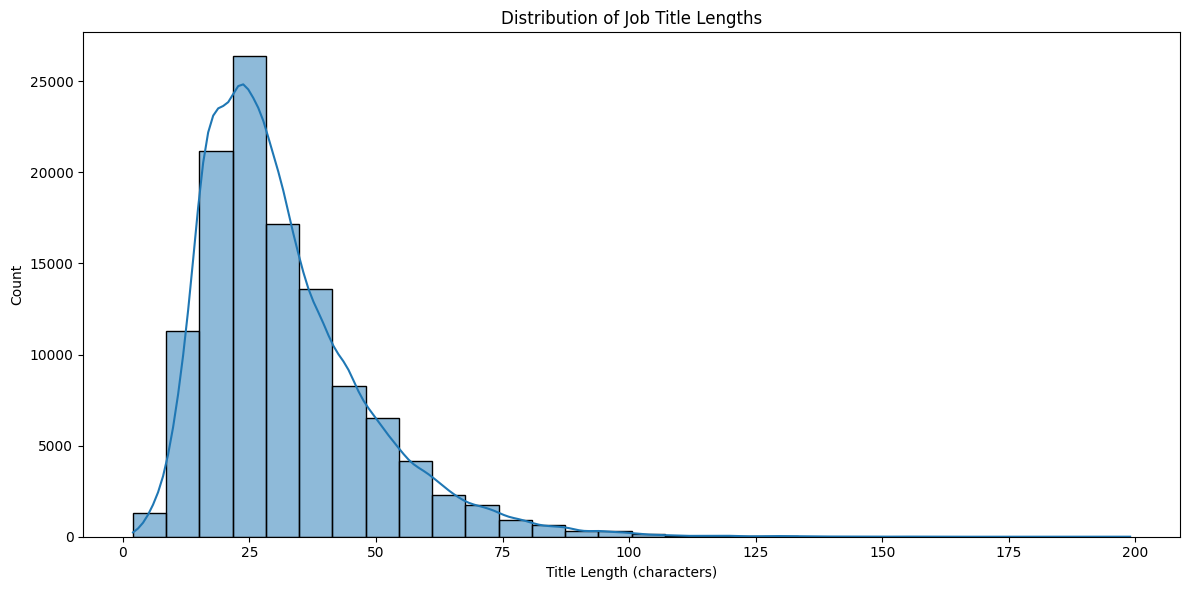

Top 10 Most Common Job Titles:
sales manager                      631
customer service representative    432
project manager                    334
assistant store manager            318
senior accountant                  232
administrative assistant           227
salesperson                        202
registered nurse                   202
executive assistant                200
receptionist                       199
Name: title, dtype: int64


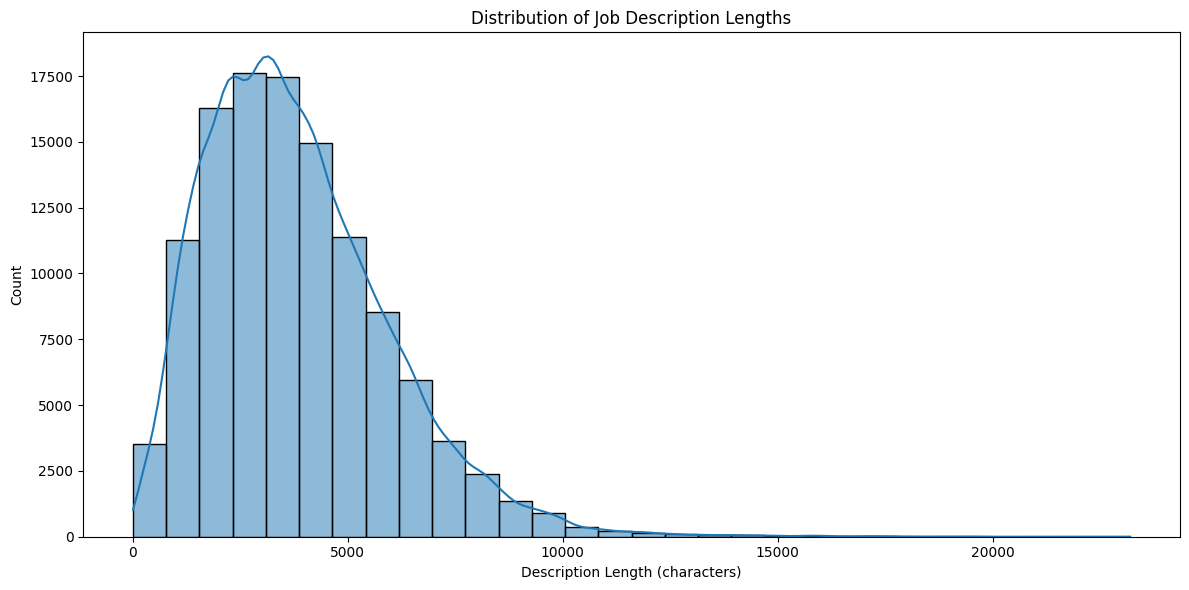

In [0]:
# Length statistics
final_compiled_clean_no_outliers['title_length'] = final_compiled_clean_no_outliers['title'].str.len()
final_compiled_clean_no_outliers['job_description_length'] = final_compiled_clean_no_outliers['job_description'].str.len()

# Plot title length distribution
plt.figure(figsize=(12, 6))
sns.histplot(final_compiled_clean_no_outliers['title_length'], bins=30, kde=True)
plt.title('Distribution of Job Title Lengths')
plt.xlabel('Title Length (characters)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Most common job titles
print("Top 10 Most Common Job Titles:")
print(final_compiled_clean_no_outliers['title'].value_counts().head(10))

# Plot job_description length distribution
plt.figure(figsize=(12, 6))
sns.histplot(final_compiled_clean_no_outliers['job_description_length'], bins=30, kde=True)
plt.title('Distribution of Job Description Lengths')
plt.xlabel('Description Length (characters)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


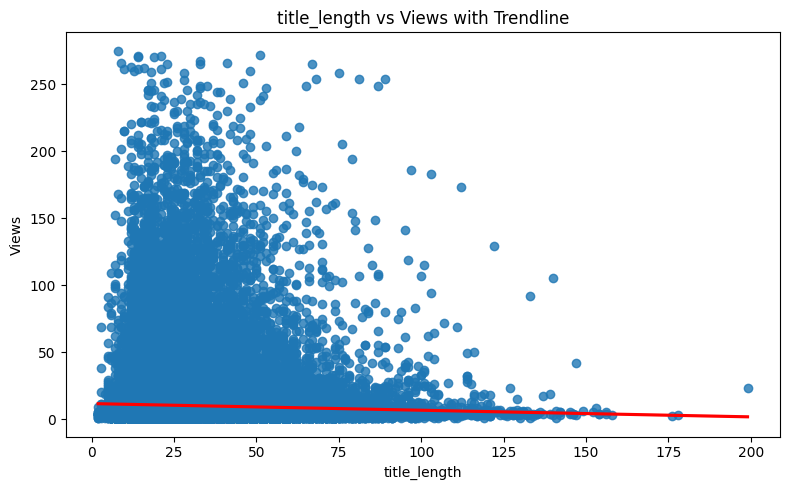

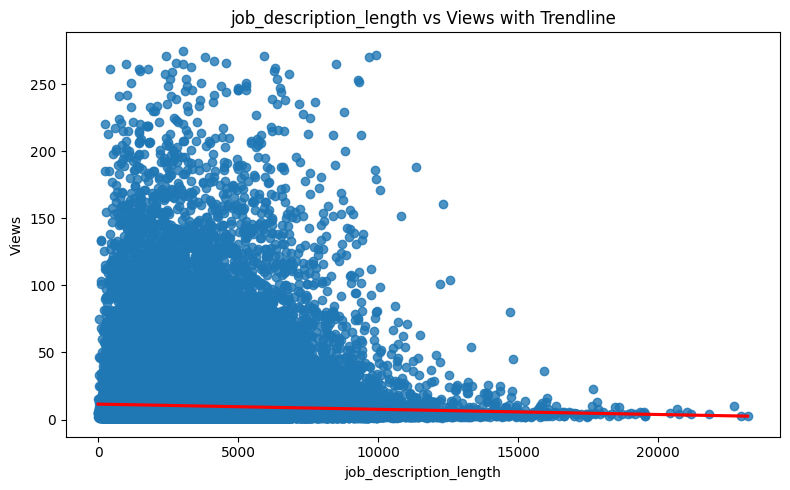

In [0]:
# Scatterplots with trendlines for numerical text-based features
text_features = ['title_length', 'job_description_length']
for feature in text_features:
    plt.figure(figsize=(8, 5))
    sns.regplot(data=final_compiled_clean_no_outliers, x=feature, y='views', scatter=True, line_kws={'color': 'red'})
    plt.title(f'{feature} vs Views with Trendline')
    plt.xlabel(feature)
    plt.ylabel('Views')
    plt.tight_layout()
    plt.show()

In [0]:
#!pip install wordcloud

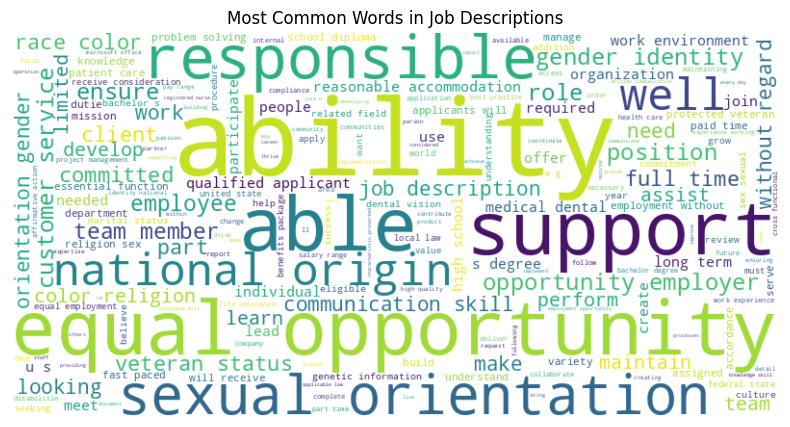

In [0]:
from wordcloud import WordCloud

# Combine all job descriptions into one string
text = ' '.join(final_compiled_clean_no_outliers['job_description'].dropna())

# Generate and plot the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Job Descriptions')
plt.show()


#### Text vectorization

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the TF-IDF vectorizer with parallel processing enabled
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100, max_df=0.95)

# Vectorize the 'job_description' column
tfidf_matrix = tfidf_vectorizer.fit_transform(final_compiled_clean_no_outliers['job_description'].fillna(''))

# Convert the sparse matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add outcome variables to the DataFrame
tfidf_df['views'] = final_compiled_clean_no_outliers['views'].reset_index(drop=True)
tfidf_df['normalized_salary'] = final_compiled_clean_no_outliers['normalized_salary'].reset_index(drop=True)

# Compute correlations with outcome variables
correlations = tfidf_df.corr()


Top 10 TF-IDF terms correlated with Views:
views                1.000000
normalized_salary    0.135668
data                 0.119971
experience           0.106811
development          0.104995
strong               0.089263
role                 0.080074
design               0.077434
business             0.077074
management           0.076120
Name: views, dtype: float64

Top 10 TF-IDF terms correlated with Normalized Salary:
normalized_salary    1.000000
business             0.230275
development          0.224968
design               0.170961
experience           0.169548
technical            0.166331
years                0.161851
data                 0.157866
management           0.152420
solutions            0.141107
Name: normalized_salary, dtype: float64

Top 10 TF-IDF terms by importance:
['ability' 'able' 'assigned' 'based' 'benefits' 'best' 'business' 'care'
 'career' 'client']


In [0]:
# Display the top 20 TF-IDF terms correlated with views and normalized salary
print("Top 20 TF-IDF terms correlated with Views:")
print(correlations['views'].sort_values(ascending=False).head(20))

print("\nTop 20 TF-IDF terms correlated with Normalized Salary:")
print(correlations['normalized_salary'].sort_values(ascending=False).head(20))

# Display the top 20 TF-IDF terms
print("\nTop 20 TF-IDF terms by importance:")
print(tfidf_vectorizer.get_feature_names_out()[:20])

Top 20 TF-IDF terms correlated with Views:
views                1.000000
normalized_salary    0.135668
data                 0.119971
experience           0.106811
development          0.104995
strong               0.089263
role                 0.080074
design               0.077434
business             0.077074
management           0.076120
years                0.070771
solutions            0.070002
technical            0.067115
project              0.062735
communication        0.061746
degree               0.059835
skills               0.058405
client               0.054204
product              0.053924
industry             0.044771
Name: views, dtype: float64

Top 20 TF-IDF terms correlated with Normalized Salary:
normalized_salary    1.000000
business             0.230275
development          0.224968
design               0.170961
experience           0.169548
technical            0.166331
years                0.161851
data                 0.157866
management           0.152420
sol

In [0]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(tfidf_matrix)

print("Top terms for each topic:")
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Top terms for each topic:
Topic 0:
['experience', 'work', 'company', 'team', 'business', 'service', 'customers', 'customer', 'store', 'sales']
Topic 1:
['experience', 'services', 'work', 'job', 'time', 'benefits', 'medical', 'health', 'patient', 'care']
Topic 2:
['systems', 'work', 'team', 'skills', 'development', 'technical', 'management', 'design', 'experience', 'project']
Topic 3:
['company', 'position', 'duties', 'ability', 'experience', 'safety', 'required', 'job', 'equipment', 'work']
Topic 4:
['skills', 'management', 'team', 'work', 'client', 'clients', 'business', 'financial', 'data', 'experience']


#### Create days_listed feature

In [0]:
# Create the `time_listed_len` feature in days
final_compiled_clean_no_outliers['days_listed'] = (final_compiled_clean_no_outliers['expiry'] - final_compiled_clean_no_outliers['listed_time']).dt.days


In [0]:
print(final_compiled_clean_no_outliers['days_listed'].info())
print(final_compiled_clean_no_outliers['days_listed'].describe())
print(final_compiled_clean_no_outliers['days_listed'].isnull().sum())

<class 'pandas.core.series.Series'>
RangeIndex: 116422 entries, 0 to 116421
Series name: days_listed
Non-Null Count   Dtype
--------------   -----
116422 non-null  int64
dtypes: int64(1)
memory usage: 909.7 KB
None
count    116422.000000
mean         33.601673
std          23.297029
min           3.000000
25%          30.000000
50%          30.000000
75%          30.000000
max         180.000000
Name: days_listed, dtype: float64
0


In [0]:
final_compiled_clean_no_outliers.describe()

,job_id,company_id,views,applies,remote_allowed,normalized_salary,work_type_Contract,work_type_Full-time,work_type_Internship,work_type_Other,work_type_Part-time,work_type_Temporary,work_type_Volunteer,experience_Associate,experience_Director,experience_Entry_level,experience_Executive,experience_Internship,experience_Mid-Senior_level,experience_unspecified,pay_period_BIWEEKLY,pay_period_HOURLY,pay_period_MONTHLY,pay_period_WEEKLY,pay_period_YEARLY,currency_BBD,currency_CAD,currency_EUR,currency_GBP,currency_USD,app_type_ComplexOnsiteApply,app_type_OffsiteApply,app_type_SimpleOnsiteApply,app_type_UnknownApply,link_to_application,salary_listed,skill_Accounting/Auditing,skill_Administrative,skill_Advertising,skill_Analyst,...,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_united_states,state_unspecified,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,industry__Agriculture,industry__Construction,industry__Education,industry__Energy,industry__Finance,industry__Government,industry__Healthcare,industry__Hospitality,industry__Manufacturing,industry__Media_&_Entertainment,industry__Non-Profit,industry__Not_specified,industry__Professional_Services,industry__Real_Estate,industry__Retail,industry__Technology,industry__Transportation,industry__Utilities,title_length,job_description_length,days_listed
count,1.164220e+05,1.164220e+05,116422.000000,116422.000000,116422.000000,33473.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,...,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000
mean,3.897332e+09,1.186992e+07,10.027435,1.046160,0.112943,92986.001622,0.094492,0.800673,0.007344,0.003693,0.079384,0.009809,0.004604,0.079865,0.030896,0.309357,0.009689,0.012111,0.341843,0.216239,0.000026,0.119806,0.004174,0.001520,0.161988,0.000017,0.000017,0.000043,0.000017,0.287420,0.231881,0.706542,0.061569,0.000009,0.727981,0.287514,0.040912,0.038489,0.005042,0.030604,...,0.049896,0.029153,0.006640,0.010539,0.034143,0.002517,0.013339,0.001357,0.015521,0.086874,0.128318,0.001022,0.008040,0.029908,0.001460,0.020847,0.015444,0.003539,0.001039,0.000902,0.033945,0.027211,0.014018,0.086805,0.017462,0.175302,0.036385,0.130955,0.022573,0.016036,0.001288,0.135842,0.016852,0.114910,0.143409,0.020142,0.005961,31.657754,3820.112410,33.601673
std,6.814915e+07,2.519127e+07,19.633521,4.081961,0.316524,54253.537849,0.292514,0.399496,0.085382,0.060662,0.270338,0.098555,0.067696,0.271085,0.173037,0.462231,0.097955,0.109383,0.474329,0.411681,0.005076,0.324735,0.064475,0.038962,0.368442,0.004145,0.004145,0.006553,0.004145,0.452561,0.422035,0.455349,0.240372,0.002931,0.445002,0.452605,0.198086,0.192375,0.070828,0.172243,...,0.217731,0.168235,0.081213,0.102119,0.181597,0.050104,0.114724,0.036814,0.123614,0.281651,0.334445,0.031955,0.089304,0.170335,0.038185,0.142871,0.123310,0.059383,0.032222,0.030018,0.181090,0.162699,0.117565,0.281550,0.130987,0.380227,0.187247,0.337352,0.148539,0.125616,0.035872,0.342622,0.128719,0.318914,0.350491,0.140487,0.076978,16.220168,2138.601252,23.297029
min,9

In [0]:
final_compiled_clean_no_outliers.isna().sum()

job_id                                 0
company_name                           0
title                                  0
job_description                        0
location                               0
company_id                             0
views                                  0
applies                                0
original_listed_time                   0
remote_allowed                         0
job_posting_url                        0
expiry                                 0
listed_time                            0
normalized_salary                  82949
city                                   0
work_type_Contract                     0
work_type_Full-time                    0
work_type_Internship                   0
work_type_Other                        0
work_type_Part-time                    0
work_type_Temporary                    0
work_type_Volunteer                    0
experience_Associate                   0
experience_Director                    0
experience_Entry

In [0]:
final_compiled_clean_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116422 entries, 0 to 116421
Columns: 167 entries, job_id to days_listed
dtypes: datetime64[ns](4), float64(44), int64(105), object(11), period[W-SUN](3)
memory usage: 148.3+ MB


In [0]:
final_compiled_clean_no_outliers.dtypes

job_id                                      int64
company_name                               object
title                                      object
job_description                            object
location                                   object
company_id                                float64
views                                     float64
applies                                   float64
original_listed_time               datetime64[ns]
remote_allowed                            float64
job_posting_url                            object
expiry                             datetime64[ns]
listed_time                        datetime64[ns]
normalized_salary                         float64
city                                       object
work_type_Contract                          int64
work_type_Full-time                         int64
work_type_Internship                        int64
work_type_Other                             int64
work_type_Part-time                         int64


### Prep Dataset for Modeling
- Exclude irrelevant features

In [0]:
# Copy dataset
modeling_dataset = final_compiled_clean_no_outliers.copy()

# Drop Irrelevant Columns
drop_columns = ['job_id', 'company_name', 'title', 'job_description', 'location', 'company_id', 'original_listed_time', 'job_posting_url', 'expiry', 'listed_time', 'city', 'name', 'company_description', 'company_size', 'company_hq_country', 'company_industry', 'company_specialities', 'time_recorded', 'original_listed_time_week', 'expiry_week', 'listed_time_week']

modeling_dataset.drop(columns=drop_columns, inplace=True, errors='ignore')

In [0]:
modeling_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116422 entries, 0 to 116421
Columns: 146 entries, views to days_listed
dtypes: float64(42), int64(104)
memory usage: 129.7 MB


In [0]:
modeling_dataset.describe()

,views,applies,remote_allowed,normalized_salary,work_type_Contract,work_type_Full-time,work_type_Internship,work_type_Other,work_type_Part-time,work_type_Temporary,work_type_Volunteer,experience_Associate,experience_Director,experience_Entry_level,experience_Executive,experience_Internship,experience_Mid-Senior_level,experience_unspecified,pay_period_BIWEEKLY,pay_period_HOURLY,pay_period_MONTHLY,pay_period_WEEKLY,pay_period_YEARLY,currency_BBD,currency_CAD,currency_EUR,currency_GBP,currency_USD,app_type_ComplexOnsiteApply,app_type_OffsiteApply,app_type_SimpleOnsiteApply,app_type_UnknownApply,link_to_application,salary_listed,skill_Accounting/Auditing,skill_Administrative,skill_Advertising,skill_Analyst,skill_Art/Creative,skill_Business_Development,...,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_united_states,state_unspecified,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,industry__Agriculture,industry__Construction,industry__Education,industry__Energy,industry__Finance,industry__Government,industry__Healthcare,industry__Hospitality,industry__Manufacturing,industry__Media_&_Entertainment,industry__Non-Profit,industry__Not_specified,industry__Professional_Services,industry__Real_Estate,industry__Retail,industry__Technology,industry__Transportation,industry__Utilities,title_length,job_description_length,days_listed
count,116422.000000,116422.000000,116422.000000,33473.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,...,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000,116422.000000
mean,10.027435,1.046160,0.112943,92986.001622,0.094492,0.800673,0.007344,0.003693,0.079384,0.009809,0.004604,0.079865,0.030896,0.309357,0.009689,0.012111,0.341843,0.216239,0.000026,0.119806,0.004174,0.001520,0.161988,0.000017,0.000017,0.000043,0.000017,0.287420,0.231881,0.706542,0.061569,0.000009,0.727981,0.287514,0.040912,0.038489,0.005042,0.030604,0.012919,0.109533,...,0.049896,0.029153,0.006640,0.010539,0.034143,0.002517,0.013339,0.001357,0.015521,0.086874,0.128318,0.001022,0.008040,0.029908,0.001460,0.020847,0.015444,0.003539,0.001039,0.000902,0.033945,0.027211,0.014018,0.086805,0.017462,0.175302,0.036385,0.130955,0.022573,0.016036,0.001288,0.135842,0.016852,0.114910,0.143409,0.020142,0.005961,31.657754,3820.112410,33.601673
std,19.633521,4.081961,0.316524,54253.537849,0.292514,0.399496,0.085382,0.060662,0.270338,0.098555,0.067696,0.271085,0.173037,0.462231,0.097955,0.109383,0.474329,0.411681,0.005076,0.324735,0.064475,0.038962,0.368442,0.004145,0.004145,0.006553,0.004145,0.452561,0.422035,0.455349,0.240372,0.002931,0.445002,0.452605,0.198086,0.192375,0.070828,0.172243,0.112924,0.312308,...,0.217731,0.168235,0.081213,0.102119,0.181597,0.050104,0.114724,0.036814,0.123614,0.281651,0.334445,0.031955,0.089304,0.170335,0.038185,0.142871,0.123310,0.059383,0.032222,0.030018,0.181090,0.162699,0.117565,0.281550,0.130987,0.380227,0.187247,0.337352,0.148539,0.125616,0.035872,0.342622,0.128719,0.318914,0.350491,0.140487,0.076978,16.220168,2138.601252,2

In [0]:
modeling_dataset.head()

,views,applies,remote_allowed,normalized_salary,work_type_Contract,work_type_Full-time,work_type_Internship,work_type_Other,work_type_Part-time,work_type_Temporary,work_type_Volunteer,experience_Associate,experience_Director,experience_Entry_level,experience_Executive,experience_Internship,experience_Mid-Senior_level,experience_unspecified,pay_period_BIWEEKLY,pay_period_HOURLY,pay_period_MONTHLY,pay_period_WEEKLY,pay_period_YEARLY,currency_BBD,currency_CAD,currency_EUR,currency_GBP,currency_USD,app_type_ComplexOnsiteApply,app_type_OffsiteApply,app_type_SimpleOnsiteApply,app_type_UnknownApply,link_to_application,salary_listed,skill_Accounting/Auditing,skill_Administrative,skill_Advertising,skill_Analyst,skill_Art/Creative,skill_Business_Development,...,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_united_states,state_unspecified,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,industry__Agriculture,industry__Construction,industry__Education,industry__Energy,industry__Finance,industry__Government,industry__Healthcare,industry__Hospitality,industry__Manufacturing,industry__Media_&_Entertainment,industry__Non-Profit,industry__Not_specified,industry__Professional_Services,industry__Real_Estate,industry__Retail,industry__Technology,industry__Transportation,industry__Utilities,title_length,job_description_length,days_listed
0,3.0,0.0,0.0,NaN,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,20,4859,30
1,3.0,0.0,0.0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,46,4837,30
2,4.0,0.0,0.0,NaN,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,30,4370,30
3,4.0,0.0,0.0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,47,6835,30
4,2.0,0.0,0.0,NaN,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21,3848,30


In [0]:
modeling_dataset.isna().sum()

views                                  0
applies                                0
remote_allowed                         0
normalized_salary                  82949
work_type_Contract                     0
work_type_Full-time                    0
work_type_Internship                   0
work_type_Other                        0
work_type_Part-time                    0
work_type_Temporary                    0
work_type_Volunteer                    0
experience_Associate                   0
experience_Director                    0
experience_Entry_level                 0
experience_Executive                   0
experience_Internship                  0
experience_Mid-Senior_level            0
experience_unspecified                 0
pay_period_BIWEEKLY                    0
pay_period_HOURLY                      0
pay_period_MONTHLY                     0
pay_period_WEEKLY                      0
pay_period_YEARLY                      0
currency_BBD                           0
currency_CAD    

### Data Versions

#### V1: model_data_final_norm_sal
- For predicting both normalized_salary and views
- Drop NAs in normalized_salary
- Drop salary_listed dummy

In [0]:
# Dataset for predicting normalized_salary and views
model_data_final_norm_sal = modeling_dataset.copy()

# Drop rows where normalized_salary is NA
model_data_final_norm_sal = model_data_final_norm_sal.dropna(subset=['normalized_salary'])

# Drop the salary_listed dummy variable
model_data_final_norm_sal = model_data_final_norm_sal.drop(columns=['salary_listed'], errors='ignore')

In [0]:
print("Dataset for Predicting Normalized Salary and Views:")
print(model_data_final_norm_sal.info())
print(model_data_final_norm_sal.shape)
print(model_data_final_norm_sal.head())
print(model_data_final_norm_sal.describe())

Dataset for Predicting Normalized Salary and Views:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33473 entries, 7 to 116421
Columns: 145 entries, views to days_listed
dtypes: float64(42), int64(103)
memory usage: 37.3 MB
None
(33473, 145)
    views  applies  ...  job_description_length  days_listed
7     6.0      0.0  ...                    5819           30
12    4.0      0.0  ...                    5414           30
17    4.0      0.0  ...                    7815           30
19    4.0      0.0  ...                    8425           30
21    5.0      0.0  ...                    2797           30

[5 rows x 145 columns]
              views       applies  ...  job_description_length   days_listed
count  33473.000000  33473.000000  ...            33473.000000  33473.000000
mean      12.033788      1.448451  ...             3958.630448     35.321154
std       22.575681      4.747186  ...             2290.186050     28.187158
min        1.000000      0.000000  ...                3.00

In [0]:
# Save model_data_final_norm_sal

# Convert pandas DataFrame to PySpark DataFrame
spark_model_data_final_norm_sal = spark.createDataFrame(model_data_final_norm_sal)

# Saved model_data_final_norm_sal as new Delta table
spark_model_data_final_norm_sal.write.format("delta").mode("overwrite").saveAsTable("default.model_data_final_norm_sal")

#### V2: model_data_final_views
- For predicting views
- Drop normalized_salary 
- Use salary_listed dummy as proxy

In [0]:
# Dataset for predicting views only
model_data_final_views = modeling_dataset.copy()

# Drop the normalized_salary column
model_data_final_views = model_data_final_views.drop(columns=['normalized_salary'], errors='ignore')


In [0]:
print("\nDataset for Predicting Views Only:")
print(model_data_final_views.info())
print(model_data_final_views.shape)
print(model_data_final_views.head())
print(model_data_final_views.describe())


Dataset for Predicting Views Only:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116422 entries, 0 to 116421
Columns: 145 entries, views to days_listed
dtypes: float64(41), int64(104)
memory usage: 128.8 MB
None
(116422, 145)
   views  applies  ...  job_description_length  days_listed
0    3.0      0.0  ...                    4859           30
1    3.0      0.0  ...                    4837           30
2    4.0      0.0  ...                    4370           30
3    4.0      0.0  ...                    6835           30
4    2.0      0.0  ...                    3848           30

[5 rows x 145 columns]
               views        applies  ...  job_description_length    days_listed
count  116422.000000  116422.000000  ...           116422.000000  116422.000000
mean       10.027435       1.046160  ...             3820.112410      33.601673
std        19.633521       4.081961  ...             2138.601252      23.297029
min         1.000000       0.000000  ...                2.000000 

In [0]:
# Save model_data_final_views

# Convert pandas DataFrame to PySpark DataFrame
spark_model_data_final_views = spark.createDataFrame(model_data_final_views)

# Saved model_data_final_views as new Delta table
spark_model_data_final_views.write.format("delta").mode("overwrite").saveAsTable("default.model_data_final_views")